# Pypi dependency

### Github Repository
A link to the repository is avaliable [here](https://github.com/MathiasDamsgaard/Comp_Social_Sci_Assigments.git).

### Contribution statement
We all helped each other with the different parts of the project. For choosing the topic and collecting the data we all helped and contributed equally. Later on, Anton took responsability for the network analysis, Andreas then stood for the textual analysis, and Mathias for the webpage and overall layout. Everyone still helped working on every part to properly agree on the final conclusions.

### Webpage
You might have to run and create the webpage first, but afterwards this [link](http://localhost:1313/Comp_Social_Sci_Assigment_B/) should work.

## Motivation

What is your dataset?

This project works to investigate a network constructed of _python packages' dependencies_ on each other. This is based on the available packages on [python package index (pypi)](https://pypi.org/). Inspiration of this project idea comes from seeing an older dataset on [Netzschleuder](https://networks.skewed.de/net/python_dependency) made by Kevin Gullikson. His [original blogpost](https://kgullikson88.github.io/blog/pypi-analysis.html) is from 2016, and will therefore be used as a baseline for comparing the networks on a timescale.

Why did you choose this/these particular dataset(s)?

We found it interesting to research how the package library in Python has evolved over the years and further investigate which packages seem to be the hubs of all other packages. Creating libraries is a big part of programming to help make functions easier to use across files and users, and thus we hope we also will gain insight into how these libraries potentially fall into different groups to see in which fields users most often create new libraries.
By also analysing the text available in README files, we hope to gain insight into how programmers formulate themselves when writing documentation for their code, and if it varies across different groups.

What was your goal for the end user's experience? The end user is someone who looks at your website. What do you want them to learn from your analysis?

Hopefully will the end user experience a breath of fresh air when reading through our analysis. It is a different and not often seen type of network, so we would like it, if the user found our research interesting not only from a computer science point of view, but also from a social science angle. While the project is inspiried by an interest for the idea of how the libraries will link togehter, it provides more insight into the habits of programmers, and it is this idea that we hope the end user will also learn something about, while reading through our website.

#### Imports

In [2]:
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
# Modules
import requests
import json
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from bs4 import BeautifulSoup
import re
import xmlrpc.client as xc
from tqdm import tqdm
import pickle
import aiohttp
import asyncio
import time
import networkx as nx
import matplotlib.pyplot as plt
import netwulf as wulf
import numpy as np
import math
import random
from community import community_louvain
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import bigrams as make_bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures
from scipy import stats
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud as wc
import ast

In [3]:
image_folder = 'Webpage/static/images/'

## Data Acqusition

First we collect all avaliable packages on pypi's website through the use of an external client. We lower alle package names to streamline the process later on.

In [4]:
# Set client to the PyPI XML-RPC server
client = xc.ServerProxy('http://pypi.python.org/pypi')

# Get a list of all the packages
pypi_packages = client.list_packages()

# lowercase all the package names
pypi_packages = [package.lower() for package in pypi_packages]

# Save the list of packages
with open("data/packages.pkl", "wb") as f:
    pickle.dump(pypi_packages, f)

We then define a function that will check the website for a link to its Github repository, where it is expected it will be under a certian class that is located in the left column. As it is a link to a website it will have an a-tag followed by a hyperref, so we collect all these and through regex collect any and all github links. If we find more than one link, we assume the correct one to be the shortest one, which is presumptuous, but after looking through a larger handfull it is the method we found to be the most successful.

In [5]:
async def get_github_link(packages: list, semaphore: asyncio.Semaphore) -> list:
    """
    Function that takes a list of python packages and returns a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    
    packages: list
        List of python packages to search for.
        
    semaphore: asyncio.Semaphore
        Semaphore to limit the number of concurrent tasks.
        
    return: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    """
    
    all_links = []
    async with semaphore, aiohttp.ClientSession() as session:
        for i, package in enumerate(packages):
            # The link to the python package
            LINK = f"https://pypi.org/project/{package}/"
            
            # Get the HTML content of the page
            try:
                async with session.get(LINK) as r:
                    if r.status != 200:
                        print(f"Request failed for {package, i}: {r.status}")
                        continue
                    content = await r.text()
            except Exception as e:
                print(f"Request failed for {package, i}: {str(e)}")
                continue
            
            # Parse the HTML content of the page
            soup = BeautifulSoup(content)
            
            # Get sidebar with links
            sidebar = soup.find("div", {"class": "vertical-tabs__tabs"})
            
            # Get all the links in the sidebar
            references = [link.get("href") for link in sidebar.find_all("a")]
            
            # Join into one string to regex in
            reference_text = " ".join([reference for reference in references if reference is not None])
            
            # Find the first link that contains the word "github.com"
            github_links = []
            for link in re.finditer(r"github\.com(/\w*|/\W|[-]\w*|[-]\W*)*", reference_text):
                if link.group() != "github.com/" and link.group() != "github.com":
                    github_links.append(link.group())
            
            # If there are no links, append None
            if len(github_links) == 0:
                github_link = None
            
            # If there's several take the shortest and alert the user
            elif len(github_links) > 1:
                # print(f"Several GitHub links found for {package, i}: {github_links}")
                github_link = min(github_links, key=len)
            
            # If there is just one link, take that out of the list
            elif len(github_links) == 1:
                github_link = github_links[0]
            
            # Else alert the user no githublink is found
            else:
                print(f"No GitHub link found for {package}")
                github_link = None
            
            # Append the triplet to the list
            all_links.append((package, LINK, github_link))
            
            # Sleep for a short period to avoid hitting rate limits
            await asyncio.sleep(0.1)
    
    return all_links

We then collect the links and clean up the following list to only include tuples were the github link exists.

In [6]:
import nest_asyncio
nest_asyncio.apply()

# Load packages
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)

# Create an event loop
loop = asyncio.get_event_loop()

# Create a semaphore
semaphore = asyncio.Semaphore(500)  # Adjust this value as needed

# Create a list to hold the tasks
tasks = []

chunk_size = 80

# For each chunk of packages
for chunk in [pypi_packages[i:i+chunk_size] for i in range(0, len(pypi_packages), chunk_size)]:
    # Create a task for the function and add it to the list
    task = asyncio.ensure_future(get_github_link(chunk, semaphore))
    tasks.append(task)

# Run all the tasks concurrently
all_links = loop.run_until_complete(asyncio.gather(*tasks))

# Flatten the list of lists into a single list
all_links = [link for sublist in all_links for link in sublist]

# Clean the list of None links
all_links = [(p, l, g) for p, l, g in all_links if g is not None]

# Save the list of links
with open("data/all_links_github.json", "w") as f:
    json.dump(all_links, f)

Request failed for ('card-rotator-yoshiman', 0): 404
Request failed for ('clouddbclean', 0): 404
Request failed for ('maha-cet-admission', 0): 404
Request failed for ('snorkel2', 0): 404
Request failed for ('dts-256-hasher', 0): 404
Request failed for ('updated-requests', 0): 404
Request failed for ('wordpress22', 0): 404
Request failed for ('tdb-py-dist', 0): 404
Request failed for ('metadecrypt', 0): 404
Request failed for ('ucid-api', 0): 404
Request failed for ('instagram-thief', 1): 404
Request failed for ('pyrastreadorcorreiosasync', 0): 404
Request failed for ('approx-ml', 0): 404
Request failed for ('pyasync3', 0): 404
Request failed for ('pyddos', 0): 404
Request failed for ('svgdiagram', 0): 404
Request failed for ('p-cal', 0): 404
Request failed for ('cloudkeeper-plugin-backup', 0): 404
Request failed for ('pyspacefacts', 0): 404
Request failed for ('windscribe-gen', 1): 404
Request failed for ('mypackage-akshay', 1): 404
Request failed for ('uni-grounding', 1): 404
Request 

In [7]:
all_links[0]

('ghicon', 'https://pypi.org/project/ghicon/', 'github.com/agzg/ghicon')

In [8]:
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)
print("Number of packages on pypi:", len(pypi_packages))

with open('data/all_links_github.json', 'r') as f:
    data_clean = json.load(f)
print("Number of packages to successfully get the github link from:", len(data_clean))

Number of packages on pypi: 533827
Number of packages to successfully get the github link from: 347955


The number of packages left drastically shrinks from the inital 500k+ to almost 350k. As one would normally assume public code like packages to be well documented, these do come in have sizes, where small packages only by only a handfull of people within a certain area might not put documentation up online as that is available internally. It is also possible that it wasn't every single package that had the link to the repository in the same way as the majority of packages, and we thereby lost some due to needing to make some choices on how to webscrape the data.

Following this, we then have to collect the information of off the Github repository. We want to collect both any readme file and the dependencies the package has. This is done based on another assumption, where we found out after investigating several repositories that the content files on a repo has it own URL structure of the format _https://raw.githubusercontent.com/brand-name/file-name_. Therefore, we replace the github.com with the raw URL, and just try different combinations of branch and files names. These combinations are chosen based on the results we found on different naming conventions we could find on different small and big repositories including numpy, pandas, matplotlib and pytorch. A branch was either named _main_ or _master_ and the README files ended with .md, .rst or .txt. The dependencies had a naming convention of one of the following:
* requirements-dev.txt
* dev-requiremtns.txt
* environment.yml
* pyproject.toml
* requirements.txt

If none of the combinations were successful for the dependencies we discarded the package, as we then couldn't link it properly in the network. However, if it was only the README file we couldn't find, we stil kept the package for the network analysis and would later drop for the textual analysis. We did this to stay as true to the network as possible.

In [11]:
# For each package go to the GitHub page and get the readme.text if theres a README.md
def get_readme_text(github_link: str) -> list:
    """
    Function that takes a GitHub link and returns the text of the README.md file.
    
    github_link: str
        Link to the GitHub page.
        
    return: str
        Text of the README.md file.
    """
    # If there's no link, return None
    if github_link is None:
        return None
    
    github_link = github_link.replace("github.com", "https://raw.githubusercontent.com")
    
    try:
        response = requests.get(f"{github_link}/main/README.md")
        if response.status_code != 200:
            response = requests.get(f"{github_link}/master/README.md")
            if response.status_code != 200:
                response = requests.get(f"{github_link}/main/REAMDE.rst")
                if response.status_code != 200:
                    response = requests.get(f"{github_link}/master/REAMDE.rst")
                    if response.status_code != 200:
                        response = requests.get(f"{github_link}/main/README.txt")
                        if response.status_code != 200:
                            response = requests.get(f"{github_link}/master/README.txt")
                            if response.status_code != 200:
                                return None
                            
    except Exception as e:
        print(e)
        return None
    
    readme_text = response.text
    
    try:
        readme_text = BeautifulSoup(readme_text, "html.parser")
    except:
        return None

    # Clean the text using regex
    readme_text = re.sub(r"<.*?>", "", str(readme_text))
    readme_text = re.sub(r"http.*", "", readme_text)    # Remove links which start with http
    readme_text = re.sub(r"/.*|./.*|../.*", "", readme_text)    # Remove links to files in the repository which start with / or ./ or ../
    readme_text = re.sub(r"\n", " ", readme_text)    # Convert /n to space
    readme_text = readme_text.lower()    # Make all text lowercase
    readme_text = re.sub(r"[^a-z0-9-_ ]", "", readme_text)    # Only keep Alphanumeric characters and - and _
    readme_text = re.sub(r" +", " ", readme_text)    # Remove multiple spaces
    readme_text = [line for line in readme_text.split(" ") if line != ""]    # Remove empty strings

    return readme_text


def get_requirements_text(github_link: str) -> list:
    """
    Function that takes a GitHub link and returns the text of the requirements.txt file.
    
    github_link: str
        Link to the GitHub page.
        
    return: str
        Text of the requirements.txt file.
    """
    # If there's no link, return None
    if github_link is None:
        return None
    
    github_link = github_link.replace("github.com", "https://raw.githubusercontent.com")
    

    txt_bool = True
    pyproject_bool = False

    try:
        response = requests.get(f"{github_link}/main/requirements-dev.txt")
        if response.status_code != 200:
            response = requests.get(f"{github_link}/master/requirements-dev.txt")
            if response.status_code != 200:
                response = requests.get(f"{github_link}/main/dev-requirements.txt")
                if response.status_code != 200:
                    response = requests.get(f"{github_link}/master/dev-requirements.txt")
                    if response.status_code != 200:
                        txt_bool = False
                        response = requests.get(f"{github_link}/main/environment.yml")
                        if response.status_code != 200:
                            response = requests.get(f"{github_link}/master/environment.yml")
                            if response.status_code != 200:
                                pyproject_bool = True
                                response = requests.get(f"{github_link}/main/pyproject.toml")
                                if response.status_code != 200:
                                    response = requests.get(f"{github_link}/master/pyproject.toml")
                                    if response.status_code != 200:
                                        pyproject_bool = False
                                        txt_bool = True
                                        response = requests.get(f"{github_link}/main/requirements.txt")
                                        if response.status_code != 200:
                                            response = requests.get(f"{github_link}/master/requirements.txt")
                                            if response.status_code != 200:
                                                return None

    except Exception as e:
        print(e)
        return None                                

    requirements_text = response.text

    # Clean the text using regex
    cleaning_reg = r"=.*|>.*|~.*|\[.*\]|;.*|<.*|!.*"

    if txt_bool:
        # Example: 
            # versioneer[toml]
            # cython~=3.0.5
            # meson[ninja]==1.2.1
            # meson-python==0.13.1
            # pytest>=7.3.2
            # pytest-xdist>=2.2.0
            # pytest-qt>=4.2.0
        # We only want the package name and not the version or extras
        requirements_text = re.sub(r"\[.*\]", "", requirements_text)
        requirements_text = re.sub(r"#.*", "", requirements_text)        # Remove comments
        requirements_text = re.sub(f"{cleaning_reg}", "", requirements_text)        # Clean the text using regex
        requirements_text = requirements_text.lower()        # lower case
        requirements_text = requirements_text.split("\n")        # Convert to list
        requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]        # Remove empty strings

    elif pyproject_bool:
        # Example:
            # [project]
            # name = "pydata-sphinx-theme"
            # description = "Bootstrap-based Sphinx theme from the PyData community"
            # readme = "README.md"
            # requires-python = ">=3.9"
            # dependencies = [
            # "Babel",
            # "pygments>=2.7",
            # ]
            # [project.optional-dependencies]
            # doc = [
            # "numpydoc",
            # "linkify-it-py", # for link shortening
            # "myst-parser"
            # ]

        requirements_text = re.sub(r"#.*", "", requirements_text)         # Remove comments
        dependencies = re.findall(r'dependencies = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
        optional_dependencies = re.findall(r'optional-dependencies\]\n.*? = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
        if len(dependencies) == 0:
            return None
        if len(optional_dependencies) == 0:
            optional_dependencies = [""]
        
        dependencies = re.findall(r'".*"', dependencies[0])
        optional_dependencies = re.findall(r'".*"', optional_dependencies[0])
        requirements_text = dependencies + optional_dependencies
        requirements_text = [requirement[1:-1] for requirement in requirements_text]         # Remove double quotes
        requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]         # Clean the text using regex
        requirements_text = [requirement.lower() for requirement in requirements_text]         # lower case
        requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]         # Remove empty strings

    else:
        # Example:
            # name: myenv
            # channels:
            #   - defaults
            # dependencies:
            #   - numpy
            #   - pip
            #   - pip:
            #     - matplotlib
        
        requirements_text = re.sub(r"#.*", "", requirements_text)        # Remove comments
        requirements_text = re.findall(r"- .*", requirements_text)        # Only get the dependencies which start with '- '
        requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]        # Clean the text using regex
        requirements_text = [requirement.lower() for requirement in requirements_text]        # lower case
        requirements_text = [requirement[2:] for requirement in requirements_text]        # Convert to list
        requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
        requirements_text = [requirement for requirement in requirements_text if requirement != ""]        # Remove empty strings

           
    return requirements_text


def node_creator(data: Tuple[str, str, str]) -> Dict[str, Any]:
    """
    Function that takes a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page and returns a dictionary with the package name as the key and the value is a dictionary with the package name, the link to the PyPI page, the link to the GitHub page, the text of the README.md file and the text of the requirements.txt file.
    
    data: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
        
    return: dict
        Dictionary with the package name as the key and the value is a dictionary with the package name, the link to the PyPI page, the link to the GitHub page, the text of the README.md file and the text of the requirements.txt file.
    """
    node = {}
    
    package, link, github_link = data

    readme_text = get_readme_text(github_link)
    requirements_text = get_requirements_text(github_link)
    if requirements_text is None:
        return None
    node[package] = {"package": package, "link": link, "github_link": github_link, "readme_text": readme_text, "requirements_text": requirements_text}
    
    return node

# Test the function
test_data = ('numpy', 'https://pypi.org/project/numpy/', 'github.com/numpy/numpy')
test_node = node_creator(test_data)
print(test_node)

{'numpy': {'package': 'numpy', 'link': 'https://pypi.org/project/numpy/', 'github_link': 'github.com/numpy/numpy', 'readme_text': ['powered', 'by', 'numfocus', 'pypi', 'downloads', 'conda', 'downloads', 'stack', 'overflow', 'nature', 'paper', 'openssf', 'scorecard', 'numpy', 'is', 'the', 'fundamental', 'package', 'for', 'scientific', 'computing', 'with', 'python', '-', 'website', '-', 'documentation', '-', 'mailing', 'list', '-', 'source', 'code', '-', 'contributing', '-', 'bug', 'reports', '-', 'report', 'a', 'security', 'vulnerability', 'it', 'provides', '-', 'a', 'powerful', 'n-dimensional', 'array', 'object', '-', 'sophisticated', 'broadcasting', 'functions', '-', 'tools', 'for', 'integrating', '-', 'useful', 'linear', 'algebra', 'fourier', 'transform', 'and', 'random', 'number', 'capabilities', 'testing', 'numpy', 'requires', 'pytest', 'and', 'hypothesis', 'tests', 'can', 'then', 'be', 'run', 'after', 'installation', 'with', 'python', '-c', 'import', 'numpy', 'sys', 'sysexitnumpyt

In [12]:
# Load clean data
with open('data/all_links_github.json', 'r') as f:
    data = json.load(f)

# Run the function with threadpool executor to speed up the process
with ThreadPoolExecutor() as executor:
    nodes = list(tqdm(executor.map(node_creator, data), total=len(data)))

# Save the list to a json file
with open("data/nodes.json", "w") as f:
    json.dump(nodes, f)

C:\Users\anton\AppData\Local\Temp\ipykernel_57240\2475631877.py:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  readme_text = BeautifulSoup(readme_text, "html.parser")
  0%|          | 1660/347955 [04:52<11:41:37,  8.23it/s]C:\Users\anton\AppData\Local\Programs\Python\Python310\lib\html\parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)
  2%|▏         | 6661/347955 [20:07<13:31:58,  7.01it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  2%|▏         | 7077/347955 [21:01<13:46:58,  6.87it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  3%|▎         | 9218/347955 [25:56<10:52:45,  8.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  3%|▎         | 10559/347955 [29:10<16:16:07,  5.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  3%|▎         | 11978/347955 [32:43<17:53:43,  5.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▎         | 12289/347955 [33:26<11:44:59,  7.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▎         | 12597/347955 [34:11<10:50:43,  8.59it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▎         | 12623/347955 [34:14<16:13:31,  5.74it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▎         | 12670/347955 [34:22<20:53:44,  4.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▎         | 12872/347955 [34:54<15:39:34,  5.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▎         | 12897/347955 [34:57<13:25:26,  6.93it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13324/347955 [36:01<19:20:04,  4.81it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13355/347955 [36:06<13:35:07,  6.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13417/347955 [36:15<10:22:10,  8.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13536/347955 [36:32<10:16:33,  9.04it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13548/347955 [36:34<10:00:54,  9.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13587/347955 [36:39<13:05:18,  7.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13599/347955 [36:41<11:31:42,  8.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13631/347955 [36:45<11:21:44,  8.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13652/347955 [36:48<15:35:27,  5.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 13657/347955 [36:49<10:36:53,  8.75it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14205/347955 [38:05<12:47:15,  7.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14307/347955 [38:20<16:41:13,  5.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14449/347955 [38:40<16:10:04,  5.73it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14708/347955 [39:15<11:33:11,  8.01it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14794/347955 [39:27<11:09:34,  8.29it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14888/347955 [39:44<28:52:37,  3.20it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 14979/347955 [40:02<20:16:17,  4.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 15075/347955 [40:17<9:33:21,  9.68it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 15407/347955 [41:06<11:21:21,  8.13it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 15435/347955 [41:10<13:52:32,  6.66it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  4%|▍         | 15566/347955 [41:28<10:41:22,  8.64it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  5%|▍         | 15751/347955 [41:55<13:29:07,  6.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  5%|▍         | 16608/347955 [43:56<17:50:51,  5.16it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  5%|▌         | 17522/347955 [46:07<10:01:08,  9.16it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  5%|▌         | 17609/347955 [46:18<10:30:07,  8.74it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  5%|▌         | 18644/347955 [48:46<12:02:38,  7.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▊         | 29911/347955 [1:21:46<9:44:14,  9.07it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 30771/347955 [1:23:47<11:19:18,  7.78it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 31570/347955 [1:25:36<9:55:41,  8.85it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 31672/347955 [1:25:50<8:44:22, 10.05it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 31925/347955 [1:26:27<15:01:33,  5.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 32108/347955 [1:26:53<10:05:12,  8.70it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 32404/347955 [1:27:36<12:53:23,  6.80it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 32422/347955 [1:27:37<7:30:17, 11.68it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 32461/347955 [1:27:43<11:52:39,  7.38it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 32750/347955 [1:28:22<10:08:05,  8.64it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


  9%|▉         | 32794/347955 [1:28:27<8:05:51, 10.81it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33460/347955 [1:29:58<12:35:10,  6.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33464/347955 [1:29:59<12:40:35,  6.89it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33470/347955 [1:29:59<9:31:36,  9.17it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33749/347955 [1:30:36<10:37:16,  8.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33809/347955 [1:30:44<12:36:31,  6.92it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33856/347955 [1:30:50<9:57:31,  8.76it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33867/347955 [1:30:51<8:18:14, 10.51it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33882/347955 [1:30:53<10:53:02,  8.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 33978/347955 [1:31:06<10:28:02,  8.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34035/347955 [1:31:14<13:03:49,  6.67it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34368/347955 [1:32:04<13:28:38,  6.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34500/347955 [1:32:23<10:51:38,  8.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34564/347955 [1:32:31<9:20:34,  9.32it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34679/347955 [1:32:51<19:03:50,  4.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34720/347955 [1:32:57<11:10:21,  7.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34746/347955 [1:33:01<9:13:01,  9.44it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|▉         | 34747/347955 [1:33:01<9:44:31,  8.93it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 34806/347955 [1:33:09<10:55:42,  7.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 34896/347955 [1:33:22<11:48:27,  7.36it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 34966/347955 [1:33:31<15:14:03,  5.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 34976/347955 [1:33:32<9:22:24,  9.27it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35086/347955 [1:33:49<8:57:58,  9.69it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35120/347955 [1:33:54<15:09:38,  5.73it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35325/347955 [1:34:22<12:10:55,  7.13it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35683/347955 [1:35:12<11:19:28,  7.66it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35791/347955 [1:35:26<6:55:28, 12.52it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35850/347955 [1:35:34<7:46:02, 11.16it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 35878/347955 [1:35:38<13:09:27,  6.59it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 36041/347955 [1:36:02<12:01:23,  7.21it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 36161/347955 [1:36:19<10:16:55,  8.42it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 36167/347955 [1:36:20<10:20:46,  8.37it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 10%|█         | 36234/347955 [1:36:30<14:31:14,  5.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 36590/347955 [1:37:19<9:50:55,  8.78it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 36809/347955 [1:37:50<11:33:48,  7.47it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 36844/347955 [1:37:54<12:42:58,  6.80it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 36903/347955 [1:38:02<18:45:33,  4.61it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37030/347955 [1:38:20<8:50:23,  9.77it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37239/347955 [1:38:49<14:53:43,  5.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37346/347955 [1:39:04<13:49:20,  6.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37510/347955 [1:39:29<14:47:39,  5.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37528/347955 [1:39:31<9:07:41,  9.45it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37637/347955 [1:39:47<10:54:24,  7.90it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37824/347955 [1:40:14<14:33:11,  5.92it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 37952/347955 [1:40:31<11:38:02,  7.40it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38003/347955 [1:40:39<16:05:01,  5.35it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38012/347955 [1:40:40<9:24:49,  9.15it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38061/347955 [1:40:47<11:00:31,  7.82it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38119/347955 [1:40:54<11:50:38,  7.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38206/347955 [1:41:06<11:58:18,  7.19it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38327/347955 [1:41:23<9:24:10,  9.15it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38529/347955 [1:41:52<16:58:10,  5.07it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38645/347955 [1:42:07<9:40:35,  8.88it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38695/347955 [1:42:13<11:30:41,  7.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38732/347955 [1:42:20<17:50:44,  4.81it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38778/347955 [1:42:26<10:49:05,  7.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38829/347955 [1:42:33<12:48:15,  6.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 38845/347955 [1:42:35<10:57:40,  7.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 39064/347955 [1:43:06<10:48:37,  7.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 39071/347955 [1:43:07<10:08:26,  8.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█         | 39087/347955 [1:43:09<13:10:08,  6.52it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39191/347955 [1:43:25<19:02:05,  4.51it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39210/347955 [1:43:28<11:13:04,  7.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39212/347955 [1:43:29<10:19:05,  8.31it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39236/347955 [1:43:32<10:43:16,  8.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39339/347955 [1:43:46<14:04:35,  6.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39371/347955 [1:43:50<8:46:08,  9.77it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39471/347955 [1:44:04<13:05:14,  6.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39538/347955 [1:44:13<10:06:23,  8.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39553/347955 [1:44:15<7:11:55, 11.90it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39583/347955 [1:44:19<10:59:24,  7.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39654/347955 [1:44:29<14:26:50,  5.93it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39719/347955 [1:44:38<12:44:22,  6.72it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39732/347955 [1:44:40<11:20:13,  7.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 11%|█▏        | 39862/347955 [1:44:58<11:17:16,  7.58it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 40200/347955 [1:45:47<11:27:43,  7.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 40745/347955 [1:47:02<12:59:04,  6.57it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 40867/347955 [1:47:18<9:27:13,  9.02it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 40950/347955 [1:47:28<10:01:20,  8.51it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 41444/347955 [1:48:34<8:36:11,  9.90it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 41450/347955 [1:48:36<12:00:48,  7.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 41488/347955 [1:48:43<18:30:03,  4.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 41626/347955 [1:49:03<12:35:33,  6.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 42061/347955 [1:50:04<9:29:33,  8.95it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 42089/347955 [1:50:08<8:58:34,  9.47it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 12%|█▏        | 42317/347955 [1:50:40<11:29:42,  7.39it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 15%|█▍        | 50999/347955 [2:18:26<13:25:26,  6.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 15%|█▍        | 51685/347955 [2:19:59<16:30:51,  4.98it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 15%|█▍        | 52037/347955 [2:20:50<10:15:31,  8.01it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 15%|█▌        | 52319/347955 [2:21:26<12:09:47,  6.75it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 15%|█▌        | 52554/347955 [2:21:58<10:24:13,  7.89it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 16%|█▌        | 54492/347955 [2:26:19<9:36:43,  8.48it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 16%|█▌        | 55028/347955 [2:27:32<8:13:09,  9.90it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 57992/347955 [2:34:10<8:06:05,  9.94it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 59802/347955 [2:38:14<10:43:21,  7.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60066/347955 [2:38:50<8:46:09,  9.12it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60115/347955 [2:38:57<9:21:29,  8.54it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60172/347955 [2:39:03<9:13:17,  8.67it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60206/347955 [2:39:08<8:56:12,  8.94it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60377/347955 [2:39:29<8:06:46,  9.85it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60384/347955 [2:39:30<10:12:21,  7.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60458/347955 [2:39:40<14:10:41,  5.63it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60702/347955 [2:40:09<9:53:18,  8.07it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60710/347955 [2:40:10<9:58:31,  8.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60748/347955 [2:40:15<14:04:03,  5.67it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60756/347955 [2:40:15<7:24:37, 10.77it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 17%|█▋        | 60858/347955 [2:40:28<8:48:24,  9.06it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 60958/347955 [2:40:39<6:24:35, 12.44it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61075/347955 [2:40:56<9:14:07,  8.63it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61303/347955 [2:41:24<10:30:13,  7.58it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61322/347955 [2:41:26<10:40:50,  7.45it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61483/347955 [2:41:47<16:23:38,  4.85it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61514/347955 [2:41:52<10:09:37,  7.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61731/347955 [2:42:20<7:17:04, 10.91it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61782/347955 [2:42:26<7:04:01, 11.25it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61817/347955 [2:42:30<7:55:48, 10.02it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61879/347955 [2:42:38<8:51:05,  8.98it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 61978/347955 [2:42:51<15:10:27,  5.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62089/347955 [2:43:06<10:52:43,  7.30it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62202/347955 [2:43:24<7:37:35, 10.41it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62227/347955 [2:43:28<7:47:53, 10.18it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62334/347955 [2:43:41<11:01:15,  7.20it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62362/347955 [2:43:47<14:16:30,  5.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62454/347955 [2:44:00<10:04:17,  7.87it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62460/347955 [2:44:01<10:12:30,  7.77it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62472/347955 [2:44:03<18:23:48,  4.31it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62489/347955 [2:44:05<8:56:26,  8.87it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62529/347955 [2:44:10<7:57:10,  9.97it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62559/347955 [2:44:14<8:07:50,  9.75it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62671/347955 [2:44:28<8:47:39,  9.01it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62695/347955 [2:44:31<8:55:33,  8.88it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62732/347955 [2:44:35<7:58:54,  9.93it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62869/347955 [2:44:53<10:57:10,  7.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 62880/347955 [2:44:54<9:07:24,  8.68it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63031/347955 [2:45:15<8:51:57,  8.93it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63038/347955 [2:45:16<8:52:20,  8.92it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63412/347955 [2:46:03<10:56:04,  7.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63471/347955 [2:46:11<7:30:13, 10.53it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63536/347955 [2:46:19<11:12:00,  7.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63616/347955 [2:46:28<8:23:27,  9.41it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 63941/347955 [2:47:14<9:59:35,  7.89it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 64074/347955 [2:47:30<7:12:42, 10.93it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 64270/347955 [2:47:55<7:42:32, 10.22it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 18%|█▊        | 64339/347955 [2:48:04<9:29:34,  8.30it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64592/347955 [2:48:37<8:14:09,  9.56it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64766/347955 [2:48:57<6:52:54, 11.43it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64808/347955 [2:49:02<8:07:59,  9.67it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64826/347955 [2:49:04<7:34:55, 10.37it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64886/347955 [2:49:12<9:28:37,  8.30it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64974/347955 [2:49:23<8:37:13,  9.12it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 64978/347955 [2:49:24<9:09:59,  8.58it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 65028/347955 [2:49:30<8:46:33,  8.96it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 65067/347955 [2:49:35<8:43:16,  9.01it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▊        | 65237/347955 [2:49:56<8:16:28,  9.49it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 65271/347955 [2:50:01<7:46:50, 10.09it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 65356/347955 [2:50:11<9:48:35,  8.00it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 65541/347955 [2:50:35<7:32:26, 10.40it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 65774/347955 [2:51:04<10:06:04,  7.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 65793/347955 [2:51:06<7:22:45, 10.62it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 65998/347955 [2:51:32<7:22:56, 10.61it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 66057/347955 [2:51:39<8:57:18,  8.74it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 66095/347955 [2:51:44<7:23:11, 10.60it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 66122/347955 [2:51:47<8:02:35,  9.73it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 19%|█▉        | 66305/347955 [2:52:09<9:13:43,  8.48it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 20%|█▉        | 69465/347955 [3:02:13<13:30:41,  5.73it/s]C:\Users\anton\AppData\Local\Temp\ipykernel_57240\2475631877.py:40: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  readme_text = BeautifulSoup(readme_text, "html.parser")
 23%|██▎       | 79463/347955 [3:29:12<8:52:06,  8.41it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 24%|██▎       | 82126/347955 [3:34:49<7:36:22,  9.71it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 24%|██▍       | 84837/347955 [3:40:32<9:23:02,  7.79it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 24%|██▍       | 84892/347955 [3:40:39<6:44:05, 10.85it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 25%|██▍       | 85988/347955 [3:42:56<7:48:41,  9.32it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 25%|██▌       | 87238/347955 [3:45:38<9:06:06,  7.96it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 25%|██▌       | 87614/347955 [3:46:23<7:35:02,  9.54it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 25%|██▌       | 87772/347955 [3:46:44<11:19:17,  6.38it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 26%|██▌       | 89597/347955 [3:50:31<5:35:39, 12.83it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 26%|██▌       | 90314/347955 [3:52:04<8:37:05,  8.30it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 26%|██▌       | 90711/347955 [3:52:53<8:11:37,  8.72it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 28%|██▊       | 98592/347955 [4:18:42<7:49:14,  8.86it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 28%|██▊       | 99105/347955 [4:19:46<7:56:25,  8.71it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▊       | 99180/347955 [4:19:55<6:26:29, 10.73it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▊       | 99455/347955 [4:20:28<6:54:09, 10.00it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▊       | 99530/347955 [4:20:38<9:30:04,  7.26it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▊       | 99552/347955 [4:20:41<8:18:03,  8.31it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▊       | 99804/347955 [4:21:11<8:33:40,  8.05it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▉       | 100287/347955 [4:22:13<6:30:04, 10.58it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▉       | 100881/347955 [4:23:33<9:36:37,  7.14it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▉       | 101393/347955 [4:24:37<7:49:00,  8.76it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 29%|██▉       | 101980/347955 [4:25:53<8:51:16,  7.72it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 30%|██▉       | 103740/347955 [4:29:36<6:10:33, 10.98it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 30%|███       | 104919/347955 [4:32:04<7:17:23,  9.26it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 31%|███       | 106862/347955 [4:36:10<6:17:44, 10.64it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 31%|███       | 108541/347955 [4:39:42<8:50:07,  7.53it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 31%|███       | 108596/347955 [4:39:49<11:44:29,  5.66it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 32%|███▏      | 109693/347955 [4:42:05<6:34:19, 10.07it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 32%|███▏      | 110627/347955 [4:44:04<8:09:09,  8.09it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 32%|███▏      | 111046/347955 [4:44:55<6:47:11,  9.70it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 32%|███▏      | 111464/347955 [4:45:49<8:49:01,  7.45it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 32%|███▏      | 111691/347955 [4:46:18<10:54:35,  6.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 32%|███▏      | 112995/347955 [4:49:00<6:45:27,  9.66it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 33%|███▎      | 113270/347955 [4:49:36<9:07:26,  7.14it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 33%|███▎      | 114305/347955 [4:51:43<9:52:31,  6.57it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 33%|███▎      | 114496/347955 [4:52:06<6:35:43,  9.83it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 37%|███▋      | 129494/347955 [5:32:06<6:26:28,  9.42it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 37%|███▋      | 129810/347955 [5:32:43<8:53:53,  6.81it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 37%|███▋      | 129880/347955 [5:32:53<7:40:49,  7.89it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 38%|███▊      | 131977/347955 [5:37:11<4:47:48, 12.51it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 38%|███▊      | 132696/347955 [5:38:40<5:52:29, 10.18it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 39%|███▉      | 136878/347955 [5:47:26<8:00:38,  7.32it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 40%|███▉      | 138787/347955 [5:51:28<8:05:05,  7.19it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 40%|████      | 139745/347955 [5:53:29<8:11:02,  7.07it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 40%|████      | 139852/347955 [5:53:43<6:11:05,  9.35it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 40%|████      | 139855/347955 [5:53:43<7:40:21,  7.53it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 40%|████      | 139920/347955 [5:53:51<6:28:48,  8.92it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 40%|████      | 139975/347955 [5:53:58<7:20:14,  7.87it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 42%|████▏     | 147021/347955 [6:18:36<9:13:50,  6.05it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 148423/347955 [6:21:35<9:37:36,  5.76it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 149378/347955 [6:23:34<7:53:48,  6.99it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 149580/347955 [6:24:02<9:13:00,  5.98it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 149773/347955 [6:24:25<8:16:45,  6.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 149840/347955 [6:24:33<6:28:22,  8.50it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 150176/347955 [6:25:17<6:39:02,  8.26it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 150951/347955 [6:26:52<6:57:46,  7.86it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 151060/347955 [6:27:05<5:52:48,  9.30it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 151239/347955 [6:27:27<4:51:51, 11.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 151256/347955 [6:27:29<6:23:47,  8.54it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 43%|████▎     | 151299/347955 [6:27:34<5:41:19,  9.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▎     | 151426/347955 [6:27:49<6:18:25,  8.66it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▎     | 151717/347955 [6:28:25<5:40:22,  9.61it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▎     | 151731/347955 [6:28:27<7:09:58,  7.61it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▎     | 151773/347955 [6:28:32<5:27:12,  9.99it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▎     | 151877/347955 [6:28:47<12:55:33,  4.21it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▎     | 152001/347955 [6:29:02<6:27:53,  8.42it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152291/347955 [6:29:38<6:52:24,  7.91it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152316/347955 [6:29:41<5:55:14,  9.18it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152500/347955 [6:30:05<12:51:38,  4.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152523/347955 [6:30:09<7:18:59,  7.42it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152601/347955 [6:30:18<4:46:38, 11.36it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152704/347955 [6:30:31<7:39:30,  7.08it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152734/347955 [6:30:34<5:19:47, 10.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152770/347955 [6:30:39<5:10:57, 10.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 152813/347955 [6:30:44<6:44:56,  8.03it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153031/347955 [6:31:12<7:50:02,  6.91it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153151/347955 [6:31:26<7:09:51,  7.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153172/347955 [6:31:29<5:28:09,  9.89it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153216/347955 [6:31:34<5:25:04,  9.98it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153259/347955 [6:31:39<6:21:21,  8.51it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153319/347955 [6:31:47<5:23:27, 10.03it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153324/347955 [6:31:47<5:12:28, 10.38it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153354/347955 [6:31:51<6:12:31,  8.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153378/347955 [6:31:53<5:16:30, 10.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153652/347955 [6:32:27<4:57:43, 10.88it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153780/347955 [6:32:43<6:14:04,  8.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153788/347955 [6:32:44<8:59:20,  6.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153824/347955 [6:32:48<6:59:49,  7.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153895/347955 [6:32:57<6:46:13,  7.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153905/347955 [6:32:58<6:42:47,  8.03it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153919/347955 [6:32:59<5:18:33, 10.15it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153930/347955 [6:33:01<5:55:19,  9.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153973/347955 [6:33:06<6:07:51,  8.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153978/347955 [6:33:06<5:37:06,  9.59it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 153988/347955 [6:33:07<6:23:35,  8.43it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154180/347955 [6:33:33<6:04:46,  8.85it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154218/347955 [6:33:38<6:15:26,  8.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154233/347955 [6:33:40<7:46:19,  6.92it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154325/347955 [6:33:54<5:44:03,  9.38it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154389/347955 [6:34:01<5:43:43,  9.39it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154453/347955 [6:34:09<5:42:48,  9.41it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154710/347955 [6:34:41<6:35:17,  8.15it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 44%|████▍     | 154734/347955 [6:34:44<7:26:26,  7.21it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 154913/347955 [6:35:06<5:58:12,  8.98it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 154983/347955 [6:35:15<5:13:31, 10.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 155038/347955 [6:35:25<17:34:29,  3.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 155167/347955 [6:35:40<6:24:29,  8.36it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 155251/347955 [6:35:50<4:05:00, 13.11it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 155478/347955 [6:36:18<5:32:45,  9.64it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 155989/347955 [6:37:22<4:31:11, 11.80it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 156133/347955 [6:37:41<5:47:06,  9.21it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 156207/347955 [6:37:50<6:49:48,  7.80it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 156261/347955 [6:37:56<6:00:43,  8.86it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 156328/347955 [6:38:05<5:41:42,  9.35it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 156361/347955 [6:38:09<7:30:21,  7.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▍     | 156423/347955 [6:38:16<5:39:26,  9.40it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 156618/347955 [6:38:41<5:06:56, 10.39it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 156727/347955 [6:38:57<6:54:04,  7.70it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 157396/347955 [6:40:20<5:54:52,  8.95it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 157554/347955 [6:40:41<11:35:42,  4.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 157614/347955 [6:40:49<5:54:46,  8.94it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 158011/347955 [6:41:37<5:24:13,  9.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 45%|████▌     | 158277/347955 [6:42:11<6:31:08,  8.08it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158521/347955 [6:42:41<6:24:01,  8.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158577/347955 [6:42:48<5:19:10,  9.89it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158596/347955 [6:42:51<8:47:38,  5.98it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158836/347955 [6:43:20<5:48:18,  9.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158895/347955 [6:43:27<4:56:50, 10.62it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158902/347955 [6:43:28<5:16:37,  9.95it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 158984/347955 [6:43:37<5:56:05,  8.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159044/347955 [6:43:45<6:53:18,  7.62it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159049/347955 [6:43:45<6:42:05,  7.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159056/347955 [6:43:46<7:00:47,  7.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159264/347955 [6:44:15<7:22:54,  7.10it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159327/347955 [6:44:22<7:45:23,  6.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159349/347955 [6:44:25<6:34:51,  7.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159361/347955 [6:44:26<5:26:31,  9.63it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159374/347955 [6:44:28<4:38:55, 11.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159423/347955 [6:44:34<6:21:39,  8.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159631/347955 [6:45:01<6:51:15,  7.63it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159766/347955 [6:45:17<7:20:40,  7.12it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159802/347955 [6:45:22<7:42:53,  6.77it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159820/347955 [6:45:24<6:28:19,  8.07it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159824/347955 [6:45:24<5:46:05,  9.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159883/347955 [6:45:32<6:21:34,  8.21it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159943/347955 [6:45:39<6:22:56,  8.18it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 159977/347955 [6:45:43<7:42:41,  6.77it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160003/347955 [6:45:46<5:07:34, 10.18it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160016/347955 [6:45:47<5:33:34,  9.39it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160053/347955 [6:45:52<5:34:56,  9.35it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160058/347955 [6:45:52<5:12:38, 10.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160125/347955 [6:46:03<5:30:32,  9.47it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160186/347955 [6:46:11<6:26:08,  8.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160314/347955 [6:46:26<6:47:06,  7.68it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160352/347955 [6:46:30<4:53:56, 10.64it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160456/347955 [6:46:43<6:04:26,  8.57it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160486/347955 [6:46:47<5:29:01,  9.50it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160499/347955 [6:46:48<6:15:33,  8.32it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160525/347955 [6:46:51<5:27:54,  9.53it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160547/347955 [6:46:54<5:40:43,  9.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160570/347955 [6:46:57<4:24:14, 11.82it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160651/347955 [6:47:07<5:08:36, 10.12it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160660/347955 [6:47:09<7:52:26,  6.61it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160711/347955 [6:47:15<5:30:45,  9.43it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160798/347955 [6:47:26<7:36:46,  6.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160806/347955 [6:47:26<5:28:04,  9.51it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160808/347955 [6:47:26<5:04:05, 10.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160812/347955 [6:47:27<5:16:10,  9.86it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160820/347955 [6:47:28<5:18:33,  9.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▌     | 160877/347955 [6:47:35<5:39:05,  9.20it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 160985/347955 [6:47:48<5:50:05,  8.90it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161251/347955 [6:48:21<6:13:43,  8.33it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161332/347955 [6:48:31<5:05:55, 10.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161424/347955 [6:48:42<6:18:54,  8.20it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161471/347955 [6:48:49<7:35:50,  6.82it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161513/347955 [6:48:54<6:44:15,  7.69it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161534/347955 [6:48:57<11:26:18,  4.53it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161543/347955 [6:48:58<5:35:06,  9.27it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161606/347955 [6:49:07<8:43:01,  5.94it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161648/347955 [6:49:12<5:30:20,  9.40it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 46%|████▋     | 161661/347955 [6:49:14<5:00:36, 10.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 161814/347955 [6:49:32<6:05:44,  8.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 161877/347955 [6:49:40<6:53:20,  7.50it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 161991/347955 [6:49:53<6:20:33,  8.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162040/347955 [6:49:59<7:00:28,  7.37it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162044/347955 [6:49:59<4:11:55, 12.30it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162093/347955 [6:50:05<6:02:09,  8.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162387/347955 [6:50:42<5:33:10,  9.28it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162397/347955 [6:50:44<7:52:07,  6.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162715/347955 [6:51:25<6:02:28,  8.52it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162831/347955 [6:51:39<6:10:27,  8.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 162976/347955 [6:51:56<5:03:27, 10.16it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163361/347955 [6:52:45<6:27:03,  7.95it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163379/347955 [6:52:47<5:32:57,  9.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163511/347955 [6:53:04<6:00:46,  8.52it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163618/347955 [6:53:17<6:37:59,  7.72it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163652/347955 [6:53:22<8:49:04,  5.81it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163661/347955 [6:53:23<7:03:29,  7.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163825/347955 [6:53:43<5:33:00,  9.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163852/347955 [6:53:46<5:42:40,  8.95it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163926/347955 [6:53:57<6:15:45,  8.16it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163950/347955 [6:54:00<5:23:06,  9.49it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 163952/347955 [6:54:00<6:13:40,  8.21it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164095/347955 [6:54:18<5:28:40,  9.32it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164157/347955 [6:54:27<6:26:17,  7.93it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164207/347955 [6:54:33<5:19:04,  9.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164336/347955 [6:54:49<5:39:20,  9.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164519/347955 [6:55:12<7:15:32,  7.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164592/347955 [6:55:20<6:11:01,  8.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164639/347955 [6:55:27<8:55:04,  5.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164730/347955 [6:55:39<8:07:12,  6.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164842/347955 [6:55:52<6:35:54,  7.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 164957/347955 [6:56:05<5:10:39,  9.82it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 165177/347955 [6:56:34<7:28:15,  6.80it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 47%|████▋     | 165257/347955 [6:56:44<7:02:23,  7.21it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165303/347955 [6:56:49<4:39:42, 10.88it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165327/347955 [6:56:52<4:35:20, 11.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165351/347955 [6:56:55<5:03:08, 10.04it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165396/347955 [6:57:01<5:33:01,  9.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165412/347955 [6:57:03<4:43:50, 10.72it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165598/347955 [6:57:25<5:32:23,  9.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165775/347955 [6:57:47<5:15:49,  9.61it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165808/347955 [6:57:51<5:48:54,  8.70it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 165862/347955 [6:57:58<7:00:15,  7.22it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 166024/347955 [6:58:18<5:33:05,  9.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 166110/347955 [6:58:28<5:01:36, 10.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 166155/347955 [6:58:34<6:18:30,  8.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 166236/347955 [6:58:45<5:49:14,  8.67it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 166258/347955 [6:58:47<6:07:01,  8.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 48%|████▊     | 166262/347955 [6:58:48<4:35:01, 11.01it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|████▉     | 173456/347955 [7:23:41<5:11:29,  9.34it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|████▉     | 173778/347955 [7:24:20<3:50:19, 12.60it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|████▉     | 173782/347955 [7:24:20<4:44:46, 10.19it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|█████     | 174002/347955 [7:24:46<5:54:55,  8.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|█████     | 174207/347955 [7:25:13<4:52:05,  9.91it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|█████     | 174818/347955 [7:26:27<6:34:47,  7.31it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|█████     | 174838/347955 [7:26:29<5:16:06,  9.13it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 50%|█████     | 175438/347955 [7:27:42<4:44:16, 10.11it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 175795/347955 [7:28:29<5:23:38,  8.87it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 175913/347955 [7:28:44<5:46:39,  8.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 176690/347955 [7:30:20<5:12:47,  9.13it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 177139/347955 [7:31:15<4:10:16, 11.38it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 177410/347955 [7:31:50<6:42:30,  7.06it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 177603/347955 [7:32:14<7:08:37,  6.62it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 177667/347955 [7:32:21<5:35:15,  8.47it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████     | 178178/347955 [7:33:25<6:04:20,  7.77it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 51%|█████▏    | 178626/347955 [7:34:22<5:19:56,  8.82it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 52%|█████▏    | 180014/347955 [7:37:12<5:18:30,  8.79it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 52%|█████▏    | 181506/347955 [7:40:17<5:30:46,  8.39it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 52%|█████▏    | 182542/347955 [7:42:25<5:33:31,  8.27it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 54%|█████▍    | 187955/347955 [7:53:30<5:50:56,  7.60it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 55%|█████▍    | 190058/347955 [7:57:46<5:10:09,  8.48it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 57%|█████▋    | 199847/347955 [8:28:10<3:43:13, 11.06it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 58%|█████▊    | 202497/347955 [8:33:39<5:39:38,  7.14it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 58%|█████▊    | 202606/347955 [8:33:52<5:25:11,  7.45it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 58%|█████▊    | 202891/347955 [8:34:27<4:25:46,  9.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 59%|█████▉    | 204590/347955 [8:38:00<8:01:43,  4.96it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 59%|█████▉    | 206679/347955 [8:42:22<4:01:26,  9.75it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 207044/347955 [8:43:12<3:57:14,  9.90it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 207370/347955 [8:43:52<4:37:07,  8.46it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 207546/347955 [8:44:13<3:30:48, 11.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 207981/347955 [8:45:06<3:48:14, 10.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208018/347955 [8:45:11<4:26:21,  8.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208033/347955 [8:45:12<3:41:30, 10.53it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208071/347955 [8:45:17<5:02:28,  7.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208086/347955 [8:45:19<4:02:04,  9.63it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208138/347955 [8:45:25<3:58:31,  9.77it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208159/347955 [8:45:28<4:56:02,  7.87it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208237/347955 [8:45:37<3:47:00, 10.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208416/347955 [8:45:58<4:44:20,  8.18it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|█████▉    | 208547/347955 [8:46:13<3:24:35, 11.36it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 208792/347955 [8:46:43<5:05:14,  7.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 208823/347955 [8:46:47<6:50:46,  5.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 208893/347955 [8:46:55<5:27:55,  7.07it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 208897/347955 [8:46:56<5:48:39,  6.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209231/347955 [8:47:37<4:04:00,  9.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209283/347955 [8:47:43<5:01:20,  7.67it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209350/347955 [8:47:54<7:42:42,  4.99it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209363/347955 [8:47:56<4:12:28,  9.15it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209408/347955 [8:48:01<3:39:56, 10.50it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209538/347955 [8:48:18<3:27:30, 11.12it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209668/347955 [8:48:34<4:24:23,  8.72it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209846/347955 [8:48:55<4:59:37,  7.68it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209854/347955 [8:48:57<6:04:12,  6.32it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209895/347955 [8:49:01<3:24:21, 11.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 209915/347955 [8:49:04<4:06:41,  9.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 210026/347955 [8:49:17<4:39:13,  8.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 210028/347955 [8:49:17<4:17:39,  8.92it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 210161/347955 [8:49:33<4:52:56,  7.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 60%|██████    | 210349/347955 [8:49:57<5:07:16,  7.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 210776/347955 [8:50:49<3:25:34, 11.12it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 210846/347955 [8:50:57<3:52:57,  9.81it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 210891/347955 [8:51:03<4:45:12,  8.01it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 211400/347955 [8:52:06<4:57:35,  7.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 211436/347955 [8:52:10<3:18:49, 11.44it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 211706/347955 [8:52:42<3:47:21,  9.99it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 211731/347955 [8:52:45<3:55:04,  9.66it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212139/347955 [8:53:38<5:25:36,  6.95it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212211/347955 [8:53:47<4:43:12,  7.99it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212374/347955 [8:54:06<5:19:51,  7.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212384/347955 [8:54:07<3:03:35, 12.31it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212400/347955 [8:54:09<4:48:36,  7.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212433/347955 [8:54:13<5:26:06,  6.93it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212452/347955 [8:54:16<5:57:12,  6.32it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212467/347955 [8:54:18<4:28:31,  8.41it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212585/347955 [8:54:32<4:39:58,  8.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212590/347955 [8:54:32<4:35:31,  8.19it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212706/347955 [8:54:47<4:51:53,  7.72it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212812/347955 [8:54:59<4:22:43,  8.57it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 212910/347955 [8:55:11<3:43:01, 10.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████    | 213006/347955 [8:55:23<3:39:40, 10.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 61%|██████▏   | 213476/347955 [8:56:22<4:56:39,  7.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 62%|██████▏   | 214384/347955 [8:58:15<4:44:22,  7.83it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 62%|██████▏   | 214910/347955 [8:59:21<5:28:59,  6.74it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 62%|██████▏   | 216030/347955 [9:01:39<6:50:54,  5.35it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 62%|██████▏   | 216132/347955 [9:01:52<4:27:09,  8.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 62%|██████▏   | 216953/347955 [9:03:35<4:55:43,  7.38it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 63%|██████▎   | 217987/347955 [9:05:42<5:06:42,  7.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 63%|██████▎   | 218053/347955 [9:05:49<2:43:11, 13.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 63%|██████▎   | 218559/347955 [9:06:52<5:19:52,  6.74it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 63%|██████▎   | 218705/347955 [9:07:10<3:54:18,  9.19it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 63%|██████▎   | 219064/347955 [9:07:52<3:31:55, 10.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 228063/347955 [9:36:58<3:59:06,  8.36it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 228586/347955 [9:38:06<5:21:48,  6.18it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 228646/347955 [9:38:13<3:47:24,  8.74it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 228820/347955 [9:38:33<3:36:49,  9.16it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 229464/347955 [9:39:50<5:41:24,  5.78it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 229708/347955 [9:40:19<3:27:40,  9.49it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 229761/347955 [9:40:25<3:52:46,  8.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▌   | 230057/347955 [9:41:03<4:15:54,  7.68it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 66%|██████▋   | 230970/347955 [9:42:51<2:58:09, 10.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 67%|██████▋   | 231664/347955 [9:44:17<3:17:22,  9.82it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 67%|██████▋   | 231890/347955 [9:44:44<2:36:41, 12.35it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 67%|██████▋   | 234736/347955 [9:50:28<4:39:20,  6.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 68%|██████▊   | 235336/347955 [9:51:43<3:48:02,  8.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 68%|██████▊   | 236188/347955 [9:53:25<4:11:14,  7.41it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 68%|██████▊   | 236489/347955 [9:54:01<2:33:42, 12.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 240391/347955 [10:01:50<4:14:13,  7.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 240399/347955 [10:01:51<3:51:52,  7.73it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 240887/347955 [10:02:52<3:08:16,  9.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 240925/347955 [10:02:56<2:12:15, 13.49it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241047/347955 [10:03:11<3:01:05,  9.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241069/347955 [10:03:14<2:33:16, 11.62it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241171/347955 [10:03:26<2:56:37, 10.08it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241186/347955 [10:03:28<4:46:06,  6.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241207/347955 [10:03:31<3:40:25,  8.07it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241214/347955 [10:03:31<2:48:43, 10.54it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241376/347955 [10:03:50<3:27:38,  8.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241475/347955 [10:04:01<2:19:19, 12.74it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241775/347955 [10:04:36<4:25:55,  6.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))
("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 69%|██████▉   | 241819/347955 [10:04:40<2:31:30, 11.68it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242078/347955 [10:05:12<3:47:39,  7.75it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242093/347955 [10:05:13<3:19:03,  8.86it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242199/347955 [10:05:26<3:18:13,  8.89it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242265/347955 [10:05:32<2:48:25, 10.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242432/347955 [10:05:52<3:38:16,  8.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242442/347955 [10:05:53<2:54:46, 10.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242506/347955 [10:06:01<3:27:29,  8.47it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242609/347955 [10:06:13<3:25:42,  8.54it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242618/347955 [10:06:14<3:10:27,  9.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242724/347955 [10:06:27<3:04:17,  9.52it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242733/347955 [10:06:29<3:35:37,  8.13it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242766/347955 [10:06:32<3:33:05,  8.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242820/347955 [10:06:39<2:58:47,  9.80it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242843/347955 [10:06:41<3:42:24,  7.88it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242856/347955 [10:06:43<3:32:18,  8.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242925/347955 [10:06:51<2:45:57, 10.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242929/347955 [10:06:52<2:48:31, 10.39it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 242965/347955 [10:06:56<2:15:35, 12.91it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243002/347955 [10:07:00<2:57:44,  9.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243098/347955 [10:07:12<2:43:29, 10.69it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243142/347955 [10:07:17<3:26:00,  8.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243187/347955 [10:07:22<3:18:16,  8.81it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243196/347955 [10:07:24<4:17:46,  6.77it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243277/347955 [10:07:35<3:19:09,  8.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243279/347955 [10:07:35<4:02:47,  7.19it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243361/347955 [10:07:45<3:08:25,  9.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243366/347955 [10:07:46<3:23:06,  8.58it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243388/347955 [10:07:48<4:32:33,  6.39it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243488/347955 [10:08:00<3:05:19,  9.40it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|██████▉   | 243537/347955 [10:08:07<4:13:44,  6.86it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|███████   | 243829/347955 [10:08:52<4:02:52,  7.15it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|███████   | 243919/347955 [10:09:06<3:59:32,  7.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 70%|███████   | 244840/347955 [10:11:34<2:32:34, 11.26it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 252945/347955 [10:34:17<2:18:56, 11.40it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 253296/347955 [10:34:56<2:10:31, 12.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 253387/347955 [10:35:07<3:07:13,  8.42it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 253871/347955 [10:36:00<2:44:13,  9.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 254180/347955 [10:36:37<2:44:55,  9.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 254319/347955 [10:36:52<2:02:00, 12.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 254834/347955 [10:37:51<2:52:56,  8.97it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 255010/347955 [10:38:11<3:55:22,  6.58it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 255233/347955 [10:38:37<2:55:46,  8.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 73%|███████▎  | 255274/347955 [10:38:42<3:30:04,  7.35it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▎  | 255748/347955 [10:39:40<2:59:49,  8.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▎  | 255792/347955 [10:39:45<2:21:56, 10.82it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▎  | 256245/347955 [10:40:39<3:24:51,  7.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▎  | 256514/347955 [10:41:12<3:06:18,  8.18it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 256668/347955 [10:41:31<2:51:40,  8.86it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 256761/347955 [10:41:42<3:07:55,  8.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 256843/347955 [10:41:52<3:46:18,  6.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 256982/347955 [10:42:08<2:10:32, 11.61it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 257223/347955 [10:42:38<3:02:21,  8.29it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 257231/347955 [10:42:38<2:24:43, 10.45it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 257402/347955 [10:42:59<2:34:26,  9.77it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 257509/347955 [10:43:11<2:37:45,  9.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 257910/347955 [10:43:59<2:13:33, 11.24it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 258069/347955 [10:44:18<3:14:39,  7.70it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 258082/347955 [10:44:19<2:54:13,  8.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 258177/347955 [10:44:30<3:24:02,  7.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 258483/347955 [10:45:07<3:04:57,  8.06it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 258650/347955 [10:45:26<2:35:38,  9.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 259042/347955 [10:46:12<2:54:49,  8.48it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 74%|███████▍  | 259205/347955 [10:46:31<3:11:34,  7.72it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 259452/347955 [10:47:00<2:50:04,  8.67it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 259557/347955 [10:47:12<2:46:10,  8.87it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 259703/347955 [10:47:29<2:02:24, 12.02it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 259713/347955 [10:47:30<2:08:19, 11.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 259952/347955 [10:47:59<2:42:06,  9.05it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 260125/347955 [10:48:19<1:52:29, 13.01it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 260274/347955 [10:48:36<2:21:30, 10.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 260413/347955 [10:48:55<2:48:44,  8.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 260808/347955 [10:49:40<2:06:27, 11.49it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▍  | 260892/347955 [10:49:50<2:35:33,  9.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261195/347955 [10:50:28<2:37:41,  9.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261205/347955 [10:50:29<2:25:23,  9.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261620/347955 [10:51:18<2:11:10, 10.97it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261651/347955 [10:51:22<3:29:06,  6.88it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261673/347955 [10:51:24<3:09:04,  7.61it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261706/347955 [10:51:28<2:32:23,  9.43it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261743/347955 [10:51:33<3:37:54,  6.59it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261770/347955 [10:51:35<2:14:04, 10.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261838/347955 [10:51:43<3:26:33,  6.95it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 261914/347955 [10:51:52<2:12:53, 10.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262042/347955 [10:52:07<2:18:38, 10.33it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262117/347955 [10:52:15<2:23:18,  9.98it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262179/347955 [10:52:22<3:11:25,  7.47it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262390/347955 [10:52:44<1:57:13, 12.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262403/347955 [10:52:46<1:51:24, 12.80it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262442/347955 [10:52:50<2:40:53,  8.86it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262542/347955 [10:53:01<2:11:45, 10.80it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 75%|███████▌  | 262588/347955 [10:53:08<2:59:13,  7.94it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 262718/347955 [10:53:23<2:07:13, 11.17it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 262830/347955 [10:53:36<3:22:36,  7.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 263145/347955 [10:54:14<2:27:56,  9.55it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 263191/347955 [10:54:19<2:21:52,  9.96it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 263377/347955 [10:54:39<2:19:41, 10.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 263391/347955 [10:54:40<2:42:28,  8.67it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264278/347955 [10:56:24<2:12:01, 10.56it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264782/347955 [10:57:23<5:15:28,  4.39it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264790/347955 [10:57:23<3:06:14,  7.44it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264908/347955 [10:57:36<1:59:30, 11.58it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264920/347955 [10:57:37<1:48:27, 12.76it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264939/347955 [10:57:40<2:47:36,  8.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 264981/347955 [10:57:45<2:31:57,  9.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▌  | 265087/347955 [10:57:57<3:01:48,  7.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▋  | 265332/347955 [10:58:27<3:45:20,  6.11it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▋  | 265396/347955 [10:58:33<2:14:03, 10.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▋  | 265822/347955 [10:59:21<2:15:30, 10.10it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 76%|███████▋  | 266097/347955 [10:59:54<2:41:10,  8.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 77%|███████▋  | 266763/347955 [11:01:12<2:12:31, 10.21it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 269907/347955 [11:07:28<2:40:48,  8.09it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 270055/347955 [11:07:45<2:34:28,  8.40it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 270115/347955 [11:07:53<2:24:41,  8.97it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 270195/347955 [11:08:03<2:58:39,  7.25it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 270221/347955 [11:08:06<2:59:10,  7.23it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 270358/347955 [11:08:22<2:23:46,  9.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 78%|███████▊  | 270611/347955 [11:08:51<1:40:17, 12.85it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 80%|████████  | 279689/347955 [11:34:29<1:40:02, 11.37it/s] 

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 80%|████████  | 279808/347955 [11:34:42<1:29:32, 12.68it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280160/347955 [11:35:23<1:51:24, 10.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280171/347955 [11:35:24<1:54:45,  9.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280184/347955 [11:35:26<2:06:59,  8.89it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280402/347955 [11:35:52<2:52:10,  6.54it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280532/347955 [11:36:07<2:43:23,  6.88it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280670/347955 [11:36:23<1:40:05, 11.20it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280687/347955 [11:36:25<2:12:40,  8.45it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 280966/347955 [11:36:58<1:53:29,  9.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281082/347955 [11:37:11<2:42:50,  6.84it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281120/347955 [11:37:15<2:00:06,  9.27it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281135/347955 [11:37:17<2:02:11,  9.11it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281229/347955 [11:37:28<1:42:17, 10.87it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281333/347955 [11:37:40<2:21:57,  7.82it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281548/347955 [11:38:07<1:49:18, 10.13it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281668/347955 [11:38:21<1:57:16,  9.42it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281697/347955 [11:38:24<2:08:07,  8.62it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281799/347955 [11:38:35<1:55:02,  9.58it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 281830/347955 [11:38:38<1:36:09, 11.46it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 282038/347955 [11:39:05<1:52:10,  9.79it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 282090/347955 [11:39:11<2:24:22,  7.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 282609/347955 [11:40:13<2:06:34,  8.60it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████  | 282699/347955 [11:40:23<2:32:20,  7.14it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████▏ | 282791/347955 [11:40:34<3:00:13,  6.03it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████▏ | 283484/347955 [11:41:58<3:08:18,  5.71it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 81%|████████▏ | 283541/347955 [11:42:04<1:40:01, 10.73it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 283789/347955 [11:42:34<2:23:53,  7.43it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 284104/347955 [11:43:12<1:15:02, 14.18it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 284626/347955 [11:44:13<1:30:34, 11.65it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 284686/347955 [11:44:20<2:29:54,  7.03it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 285075/347955 [11:45:05<1:43:37, 10.11it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 285497/347955 [11:45:55<2:03:17,  8.44it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 285558/347955 [11:46:02<1:44:46,  9.92it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 286251/347955 [11:47:27<1:30:28, 11.37it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 82%|████████▏ | 286766/347955 [11:48:30<1:57:45,  8.66it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 83%|████████▎ | 288497/347955 [11:51:56<1:55:38,  8.57it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 89%|████████▉ | 309234/347955 [12:40:11<2:36:09,  4.13it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 90%|████████▉ | 312335/347955 [12:46:11<1:27:07,  6.81it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 90%|█████████ | 313964/347955 [12:49:23<47:46, 11.86it/s]  

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 93%|█████████▎| 323856/347955 [13:08:40<34:11, 11.75it/s]  

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 93%|█████████▎| 324313/347955 [13:09:35<38:03, 10.35it/s]  

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 96%|█████████▌| 333852/347955 [13:35:31<31:08,  7.55it/s]  

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 96%|█████████▌| 333992/347955 [13:35:46<22:18, 10.43it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 97%|█████████▋| 338588/347955 [13:44:51<16:51,  9.26it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 98%|█████████▊| 340330/347955 [13:48:26<14:47,  8.59it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 98%|█████████▊| 341116/347955 [13:50:00<10:28, 10.88it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 98%|█████████▊| 342100/347955 [13:51:59<09:27, 10.32it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 99%|█████████▊| 342840/347955 [13:53:24<10:30,  8.11it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 99%|█████████▉| 343828/347955 [13:55:20<10:12,  6.73it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 99%|█████████▉| 344243/347955 [13:56:11<06:42,  9.22it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 99%|█████████▉| 345600/347955 [13:58:52<04:21,  8.99it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 99%|█████████▉| 345653/347955 [13:58:59<04:36,  8.31it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


 99%|█████████▉| 345780/347955 [13:59:13<03:31, 10.28it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


100%|█████████▉| 347063/347955 [14:01:47<01:21, 11.00it/s]

("Connection broken: InvalidChunkLength(got length b'\\r\\n', 0 bytes read)", InvalidChunkLength(got length b'\r\n', 0 bytes read))


100%|██████████| 347955/347955 [14:03:11<00:00,  6.88it/s]


## Data Preprocessing & Description

First we clean up the collected data. We remove any nodes that were none, as they didn't have any requirements we could find. Then we just make sure that the text is formatted collectly, as the text varied a bit depending on the found file format.

In [13]:
#### THIS IS THE FINAL CLEANING OF THE DATA IF NEEDED ####
with open('data/nodes.json', 'r') as f:
    data = json.load(f)

cleaned_data = []

for node in data:
    if node is None:
        continue
    # lower the keys
    node = {key.lower(): value for key, value in node.items()}
    for key, value in node.items():
        value["package"] = value["package"].lower()
        value["requirements_text"] = [requirement.strip() for requirement in value["requirements_text"]]
        value["requirements_text"] = [requirement for requirement in value["requirements_text"] if requirement != ""]
        value["requirements_text"] = [requirement.lower() for requirement in value["requirements_text"]]
        value["requirements_text"] = [re.sub(r"==.*|>=.*|<=.*|~=.*|!=.*|>.*|<.*", "", requirement) for requirement in value["requirements_text"]]
    cleaned_data.append(node)

with open("data/nodes.json", "w") as f:
    json.dump(cleaned_data, f)

We then make the edge list by first getting the names of all the packages in the network. This is used as a reference point, for whether a requirement to a package should be added to the network, as we only want pairs were both nodes are nodes we have collected dependencies for.

In [14]:
# Now we make the edgelist 
# Load the data
with open('data/nodes.json', 'r') as f:
    nodes = json.load(f)

# Get names of the packages
node_names = np.array([list(n.keys())[0] for n in nodes]) # Made into a numpy array for faster lookup

edge_list = []
packages_not_in_network = set()

for node in tqdm(nodes):
    for package in node.keys(): # Only one key in each node being the single package's name
        for requirement in node[package]["requirements_text"]:
            if requirement not in node_names:
                packages_not_in_network.add(requirement)
                continue
            edge_list.append((requirement, package))

print("Number of packages not in network:", len(packages_not_in_network))

# Save the edge list to a pickle file and csv for visualization
with open("data/edge_list.pkl", "wb") as f:
    pickle.dump(edge_list, f)

df = pd.DataFrame(edge_list, columns=["source", "target"])
df.to_csv("data/edge_list.csv", index=False)

100%|██████████| 34182/34182 [01:22<00:00, 413.11it/s]

Number of packages not in network: 19293


We find that a total of 31997 packages don't get added to the network. This is likely due to us amoing others including conda environment files, and libaries exclusive to e.g. conda-forge can't be found on pypi. If a package is dependent on a pypi package, but we couldn't find a repository or dependencies for that one, we also can't add it back into the network, after already have discarded it.

Afterwards we also make the list of dictionaries into a single dictionary mapping the package to its information. Additionally, we join together the text into one string from a list of words before making the dataframe as we otherwise would be making the list itself into a string, and since we don't have a list of indexes for the unique names, we found to make the text now made sense.

In [15]:
# Convert the list of dictionaries to a dictionary
nodes_mapping = {}

for node in nodes:
    for key, value in node.items():
        nodes_mapping[key] = value

# Join the readme text into one string
for package in nodes_mapping.keys():
    text = nodes_mapping[package]["readme_text"]
    result = " ".join(text) if text is not None else ""
    if result:
        nodes_mapping[package]["readme_text"] = result

# Save the dictionary to a csv file
df = pd.DataFrame(nodes_mapping).T
df.reset_index(inplace=True, drop=True)
df.to_csv("data/nodes_data.csv", index=False)

## Network Analysis

We're very interested in analysing our network and determine if it has any sort of meaningfullness/structure.
The best way to do this is using statistics, we get the necessesary baseline by generating random networks which can be used as a baseline,
thereafter we can see if there's a significant difference.

In [16]:
# Load the edge list
with open("data/edge_list.pkl", "rb") as f:
    edge_list = pickle.load(f)

# Take 10% of the edge list
edge_list_sample = random.sample(edge_list, math.ceil(len(edge_list)*0.1))

# Create a directed graph and add the edges
G = nx.DiGraph()
G.add_edges_from(edge_list)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Number of weakly connected components:", nx.number_weakly_connected_components(G))

Number of nodes: 12930
Number of edges: 19965
Number of weakly connected components: 588


We see here that the actual number of nodes in the network is 36723 compared to the 53156 nodes we made the edge list from. This suggest that all of some package's requirements couldn't have been part of the nodes we have information on, thus resulting to the node being completely skipped.

In [17]:
# Get the number of nodes in the connected components
number_nodes_cc = sorted([len(component) for component in nx.weakly_connected_components(G)], reverse=True)

# Get the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

print("Number of nodes in the largest weakly connected component:", G.number_of_nodes())
print("Number of nodes in the following connected components:", str(np.unique(number_nodes_cc[1:]))[1:-1].replace(" ", ", "))

Number of nodes in the largest weakly connected component: 10648
Number of nodes in the following connected components: , , 1, , , 2, , , 3, , , 4, , , 5, , , 6, , , 7, , , 8, , , 9, , 10, , 11, , 20, , 26, , 51, 907


Above can be seen, that the size of the largest weakly connected component is 36088, not drastically different from the initial network. However, by seen that the sizes of the other 302 weakly connected components all are between 1 or 9, it is small groups of nodes that are removed from the network which wouldn't add integral information to the analysis, as a weakly component is defined by being able to travese from a node in the set to any other. Thus these small groups aren't connected to the main network.

In [18]:
# Network density
density = nx.density(G)
print(f'Network density: {density}')

# Network connection between nodes
is_connected = nx.is_weakly_connected(G)
print(f'Is the network connected: {is_connected}')

# Number of isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f'Number of isolated nodes: {len(isolated_nodes)}')

# Degree
degree = dict(G.degree())
degree_values = list(degree.values())

# Strength
strength = dict(G.degree(weight='weight'))
strength_values = list(strength.values())

# Average
avg_degree = np.mean(degree_values)
avg_strength = np.mean(strength_values)

# Median
median_degree = np.median(degree_values)
median_strength = np.median(strength_values)

# Mode
mode_degree = max(set(degree_values), key=degree_values.count)
mode_strength = max(set(strength_values), key=strength_values.count)

# Minimum
min_degree = min(degree_values)
min_strength = min(strength_values)

# Maximum
max_degree = max(degree_values)
max_strength = max(strength_values)

print(f'Degree Analysis:')
print(f'Average: {avg_degree:.2f}')
print(f'Median: {median_degree}')
print(f'Mode: {mode_degree}')
print(f'Minimum: {min_degree}')
print(f'Maximum: {max_degree}')
print(f'\nStrength Analysis:')
print(f'Average: {avg_strength:.2f}')
print(f'Median: {median_strength}')
print(f'Mode: {mode_strength}')
print(f'Minimum: {min_strength}')
print(f'Maximum: {max_strength}')

Network density: 0.00015870263804148102
Is the network connected: True
Number of isolated nodes: 0
Degree Analysis:
Average: 3.38
Median: 1.0
Mode: 1
Minimum: 1
Maximum: 2163

Strength Analysis:
Average: 3.38
Median: 1.0
Mode: 1
Minimum: 1
Maximum: 2163


In [19]:
# # Display the graph with netwulf
# wulf.visualize(G, config={'zoom': 0.6, 'node_gravity': 0.2


In [20]:
# Make a random network to compare
# Calculate the number of edges in the network
L = G.number_of_edges()

# Calculate the number of nodes in the network
N = G.number_of_nodes()

# Calculate the average degree of the network
k = 2*L/N
print(f"Average degree of the real network: {k:.2f}")

# Calculate the probability p
p = k/(N-1)

print(f"Probability of a link between two nodes: {p:.2e}")

#  The Erdős-Rény model is a random network model where the probability of a link between two nodes is constant and equal to p.
#  Erdős-Rény model
def generate_random_network(N, p):
    """
    Generates a random network with N nodes and edges between nodes with probability p.

    Parameters:
        N (int): The number of nodes in the network.
        p (float): The probability of adding an edge between two nodes.

    Returns:
        G (networkx.Graph): The generated random network.
    """
    # # Create an empty graph
    # G = nx.Graph()

    # # Add N nodes
    # G.add_nodes_from(range(N))

    # # Add edges between nodes with probability p
    # for i in tqdm(range(N-1)):
    #     for j in range(i+1, N):
    #         if np.random.uniform() < p:
    #             G.add_edge(i, j)

    G = nx.generators.fast_gnp_random_graph(N, p)
    
    return G

G_rand = generate_random_network(N, p)

Average degree of the real network: 3.38
Probability of a link between two nodes: 3.17e-04


In [21]:
print(f'Log of N: {math.log(N)}')
print(f"Average degree of the random network: {2*G_rand.number_of_edges()/G_rand.number_of_nodes():.2f}")

Log of N: 9.273127360074948
Average degree of the random network: 3.38


We see that the average degree of the real and random network have an average degree over 1, and the log(N) is higher than the average degree. This means that they fall into to supercritical network regime. However we would still expect that the real network would have a different distribution of node degrees than a random network. This is tested below

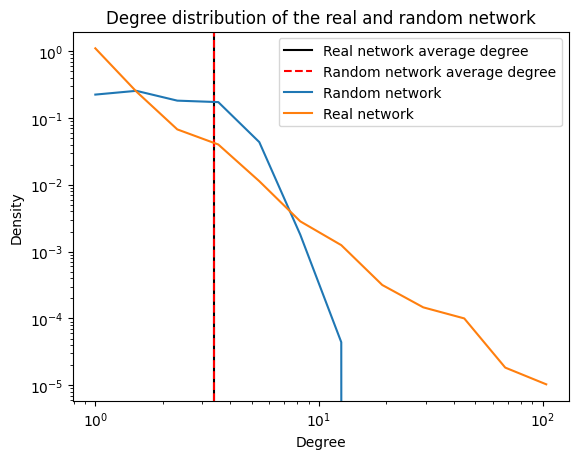

In [22]:
# Make a plot of the degree distribution
def make_plot(bins: list[list[int]], hists: list[list[int]], title: str, labels: list[str]):
    """
    Plot multiple histograms on a logarithmic scale.

    Parameters:
        bins (list[list[int]]): A list of bin edges for each histogram.
        hists (list[list[int]]): A list of histogram values for each bin.
        title (str): The title of the plot.
        labels (list[str]): A list of labels for each histogram.

    Returns:
        None
    """
    
    for bin, hist, label in zip(bins, hists, labels):
        plt.plot(bin[:-1], hist, label=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{image_folder}Degree_distribution.png', bbox_inches='tight')
    plt.show()

# Compute the distribution of degree for the random network
degree_sequence_rd = [d for _, d in G_rand.degree()]
hist_rd, bins_rd = np.histogram(degree_sequence_rd, bins=np.logspace(0, 2.2, 13), density=True)

# Compute the distribution of degree for the real network
degree_sequence = [d for _, d in G.degree()]
hist_r, bins_r = np.histogram(degree_sequence, bins=np.logspace(0, 2.2, 13), density=True)

plt.axvline(k, color='black', linestyle='-', label='Real network average degree')
plt.axvline(np.mean(degree_sequence_rd), color='red', linestyle='--', label='Random network average degree')

make_plot([bins_rd, bins_r], [hist_rd, hist_r], 'Degree distribution of the real and random network', ['Random network', 'Real network'])

We can still investigate how these hubs are interconnected. We can calculate the assortativity of the nodes:

In [23]:
def degree_assortativity(G: nx.Graph) -> float:
    """
    Calculate the degree assortativity coefficient of a graph.

    The degree assortativity coefficient measures the correlation between the degrees of connected nodes in a graph.
    It quantifies the tendency of nodes with similar degrees to be connected to each other.

    Parameters:
    - G (networkx.Graph): The input graph.

    Returns:
    - r (float): The degree assortativity coefficient of the graph.

    Prerequisites:
    - The input graph G should be an instance of the networkx.Graph class.
    - The graph should have at least one edge.

    """

    k_u = []
    k_v = []
    for u, v in G.edges():
        k_u.append(G.degree(u))
        k_v.append(G.degree(v))
    
    for x, y in G.edges():
        k_u.append(G.degree(y))
        k_v.append(G.degree(x))
    
    k_u = np.array(k_u)
    k_v = np.array(k_v)
    r = ((np.mean(k_u * k_v) - np.mean(k_u) * np.mean(k_v)) /
         (np.sqrt(np.mean(k_u**2) - np.mean(k_u)**2) * np.sqrt(np.mean(k_v**2) - np.mean(k_v)**2)))

    return r

r_degree = degree_assortativity(G.to_undirected())

print(f"Degree assortativity of the real network: {r_degree:.5f}")

Degree assortativity of the real network: -0.23553


In [24]:
# Configuation model: random network with a pre-defined degree sequence
def configuration_model(G: nx.Graph) -> nx.Graph:
    """
    Generates a configuration model graph based on the input graph G.

    The configuration model is a random graph model that preserves the degree sequence of the input graph.
    It generates a new graph by randomly rewiring edges while maintaining the same degree distribution.

    Parameters:
    - G (nx.Graph): The input graph.

    Returns:
    - nx.Graph: The generated configuration model graph.

    Prerequisites:
    - The input graph G should be an instance of the networkx Graph class.
    - The input graph G should have at least one edge.

    """

    G_copy = G.copy()
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))
    num_swaps = 10 * G_copy.number_of_edges()

    for _ in range(num_swaps):
        # Select two edges
        idx1, idx2 = random.sample(idxs, 2)
        e1, e2 = edges[idx1], edges[idx2]

        # Flip the direction of e1 50% of the time
        if random.random() < 0.5:
            e1 = (e1[1], e1[0])

        # Ensure new edges do not exist
        if e1[0] not in G_copy.neighbors(e2[1]) and e2[0] not in G_copy.neighbors(e1[1]):
            
            # Remove old edges and add new edges
            G_copy.remove_edges_from([e1, e2])
            G_copy.add_edges_from([(e1[0], e2[1]), (e2[0], e1[1])])
    
            edges[idx1] = (e1[0], e2[1])
            edges[idx2] = (e2[0], e1[1])

    return G_copy

G_undir = G.to_undirected()
G_config = configuration_model(G_undir)

# Assert that the degree sequence of the configuration model is the same as the real network
assert all([G_undir.degree(node) == G_config.degree(node) for node in G_undir.nodes])

100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


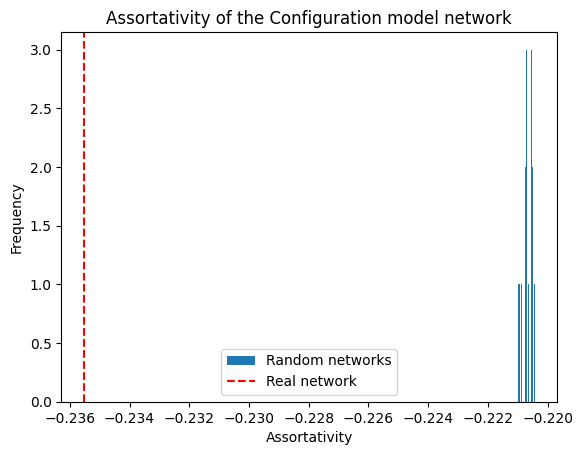

In [25]:
# Calculate the degree assortativity of multiple configuration models
assortativities = []
for _ in tqdm(range(20)):
    G_config = configuration_model(G_undir)
    r_config = degree_assortativity(G_config)
    assortativities.append(r_config)

# Plot the distribution of the assortativities
plt.hist(assortativities, bins=30, label='Random networks')

# Plot the assortativity of the original network
plt.axvline(r_degree, color='red', linestyle='--', label='Real network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the Configuration model network')
plt.legend()
plt.savefig(f'{image_folder}Assortativity.png', bbox_inches='tight')
plt.show()

In [26]:
def degree_assortativity_directed(G: nx.DiGraph):
    """
    Calculate the degree assortativity for a directed graph.

    Parameters:
    - G (nx.DiGraph): A directed graph.

    Returns:
    - r_in_in (float): Degree assortativity for in-degree of nodes.
    - r_out_out (float): Degree assortativity for out-degree of nodes.
    - r_in_out (float): Degree assortativity between in-degree and out-degree of nodes.
    - r_out_in (float): Degree assortativity between out-degree and in-degree of nodes.

    Prerequisites:
    - The input graph G should be a directed graph (nx.DiGraph).
    - The graph G should have nodes and edges defined.
    """

    # k_u and k_v are the degrees of nodes u and v, respectively
    # We get the k_u_in, k_u_out, k_v_in and k_v_out
    k_u_in = []
    k_u_out = []
    k_v_in = []
    k_v_out = []

    for u, v in G.edges():
        k_u_in.append(G.in_degree(u))
        k_v_in.append(G.in_degree(v))
        k_u_out.append(G.out_degree(u))
        k_v_out.append(G.out_degree(v))

    k_u_in = np.array(k_u_in)
    k_v_in = np.array(k_v_in)
    k_u_out = np.array(k_u_out)
    k_v_out = np.array(k_v_out)

    r_in_in = ((np.mean(k_u_in * k_v_in) - np.mean(k_u_in) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))
    
    r_out_out = ((np.mean(k_u_out * k_v_out) - np.mean(k_u_out) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_in_out = ((np.mean(k_u_in * k_v_out) - np.mean(k_u_in) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_out_in = ((np.mean(k_u_out * k_v_in) - np.mean(k_u_out) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))


    return r_in_in, r_out_out, r_in_out, r_out_in

r_in_in_real, r_out_out_real, r_in_out_real, r_out_in_real = degree_assortativity_directed(G)

print(f"In-in degree assortativity of the real network: {r_in_in_real:.5f}")
print(f"Out-out degree assortativity of the real network: {r_out_out_real:.5f}")
print(f"In-out degree assortativity of the real network: {r_in_out_real:.5f}")
print(f"Out-in degree assortativity of the real network: {r_out_in_real:.5f}")

In-in degree assortativity of the real network: 0.08077
Out-out degree assortativity of the real network: -0.00732
In-out degree assortativity of the real network: 0.00684
Out-in degree assortativity of the real network: -0.10757


In [27]:
def degree_correlation_directed(G: nx.DiGraph):
    """
    Calculate the degree correlation for a directed graph.

    Parameters:
    - G (nx.DiGraph): A directed graph.

    Returns:
    - k_u_in (dict): A dictionary with the average neighbor in-degree of node with in-degree k'.
    - k_u_out (dict): A dictionary with the average neighbor out-degree of node with out-degree k'.
    - k_v_in (dict): A dictionary with the average neighbor in-degree of node with in-degree k'.
    - k_v_out (dict): A dictionary with the average neighbor out-degree of node with out-degree k'.

    Prerequisites:
    - The input graph G should be a directed graph (nx.DiGraph).
    - The graph G should have nodes and edges defined.
    """
    
    # For each node with degree k' we want to get the average of neighbor degree in and neighbor degree out
    k_u_in = {}
    k_u_out = {}
    k_v_in = {}
    k_v_out = {}

    for u, v in G.edges():
        if G.in_degree(u) not in k_u_in:
            k_u_in[G.in_degree(u)] = []
        if G.out_degree(u) not in k_u_out:
            k_u_out[G.out_degree(u)] = []
        if G.in_degree(v) not in k_v_in:
            k_v_in[G.in_degree(v)] = []
        if G.out_degree(v) not in k_v_out:
            k_v_out[G.out_degree(v)] = []

    for u, v in G.edges():
        k_u_in[G.in_degree(u)].append(G.in_degree(v))
        k_u_out[G.out_degree(u)].append(G.out_degree(v))
        k_v_in[G.in_degree(v)].append(G.in_degree(u))
        k_v_out[G.out_degree(v)].append(G.out_degree(u))
    
    
    k_u_in = {k: np.mean(v) for k, v in k_u_in.items()}
    k_u_out = {k: np.mean(v) for k, v in k_u_out.items()}
    k_v_in = {k: np.mean(v) for k, v in k_v_in.items()}
    k_v_out = {k: np.mean(v) for k, v in k_v_out.items()}

    return k_u_in, k_u_out, k_v_in, k_v_out

k_u_in, k_u_out, k_v_in, k_v_out = degree_correlation_directed(G)

print("Average neighbor in-degree of node with in-degree k':", k_u_in)
print("Average neighbor out-degree of node with out-degree k':", k_u_out)
print("Average neighbor in-degree of node with in-degree k':", k_v_in)
print("Average neighbor out-degree of node with out-degree k':", k_v_out)

Average neighbor in-degree of node with in-degree k': {0: 3.249121833980403, 1: 3.118010752688172, 3: 3.561525129982669, 2: 3.4825956166738288, 4: 3.9496644295302015, 6: 4.136363636363637, 5: 4.333333333333333, 7: 6.0, 11: 8.214285714285714, 8: 6.0, 9: 9.25, 17: 17.0, 10: 9.666666666666666, 16: 16.0, 13: 1.0, 19: 19.0, 14: 14.0}
Average neighbor out-degree of node with out-degree k': {286: 0.0944055944055944, 83: 0.07228915662650602, 721: 0.1650485436893204, 16: 0.3392857142857143, 18: 10.74074074074074, 679: 2.662739322533137, 2163: 0.44660194174757284, 62: 0.8709677419354839, 168: 0.6428571428571429, 131: 1.6946564885496183, 1: 0.3994878361075544, 19: 0.6015037593984962, 28: 0.09821428571428571, 185: 0.11351351351351352, 49: 0.061224489795918366, 895: 0.09608938547486033, 1123: 0.9821905609973286, 42: 0.07142857142857142, 21: 0.19047619047619047, 592: 0.19425675675675674, 139: 0.17266187050359713, 12: 0.2261904761904762, 39: 0.6068376068376068, 521: 0.16314779270633398, 34: 0.1960784

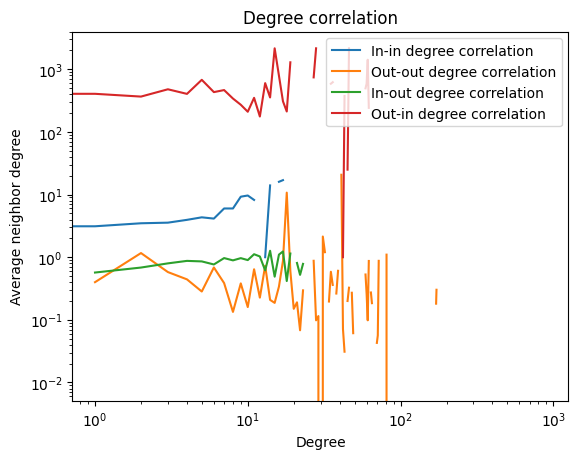

In [28]:
# Get the x values from the keys of the dictionaries
x_values = list(range(0,1000))

# Get the y values from the values of the dictionaries
y_values_in_in = [k_u_in.get(x, np.nan) for x in x_values]
y_values_out_out = [k_u_out.get(x, np.nan) for x in x_values]
y_values_in_out = [k_v_in.get(x, np.nan) for x in x_values]
y_values_out_in = [k_v_out.get(x, np.nan) for x in x_values]

# Plot the degree correlation
plt.plot(x_values, y_values_in_in, label='In-in degree correlation')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")
plt.legend(loc='upper right')
plt.title("Degree correlation")
plt.savefig(f'{image_folder}Degree_correlation.png', bbox_inches='tight')
plt.show()

In [29]:
# We do a degree preserving randomisation : R-S randomization to the plot
def degree_preserving_randomization(G: nx.DiGraph):
    """
    Perform degree-preserving randomization of a directed graph.

    Parameters:
    - G (nx.DiGraph): A directed graph.

    Returns:
    - G_copy (nx.DiGraph): The degree-preserving randomized graph.

    Prerequisites:
    - The input graph G should be a directed graph (nx.DiGraph).
    - The graph G should have nodes and edges defined.
    """

    # Create a copy of the graph
    G_copy = G.copy()

    # Get the edges and indexes
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))

    # Get the number of edges
    num_swaps = 10 * G_copy.number_of_edges()

    # For each swap
    for _ in range(num_swaps):
        # Select two sets of connected
        idx1, idx2 = random.sample(idxs, 2)
        u, v = edges[idx1]
        x, y = edges[idx2]

        # Ensure distinct nodes
        if len(set([u, v, x, y])) < 4:
            continue

        # Ensure that the new edges do not exist
        if x not in G_copy.neighbors(v) and y not in G_copy.neighbors(u):
            # Remove the old edges
            G_copy.remove_edges_from([(u, v), (x, y)])

            # Add the new edges
            G_copy.add_edges_from([(u, y), (x, v)])

            # Update the edges
            edges[idx1] = (u, y)
            edges[idx2] = (x, v)

    return G_copy

G_degree_randomized = degree_preserving_randomization(G)
k_u_in_randomized, k_u_out_randomized, k_v_in_randomized, k_v_out_randomized = degree_correlation_directed(G_degree_randomized)

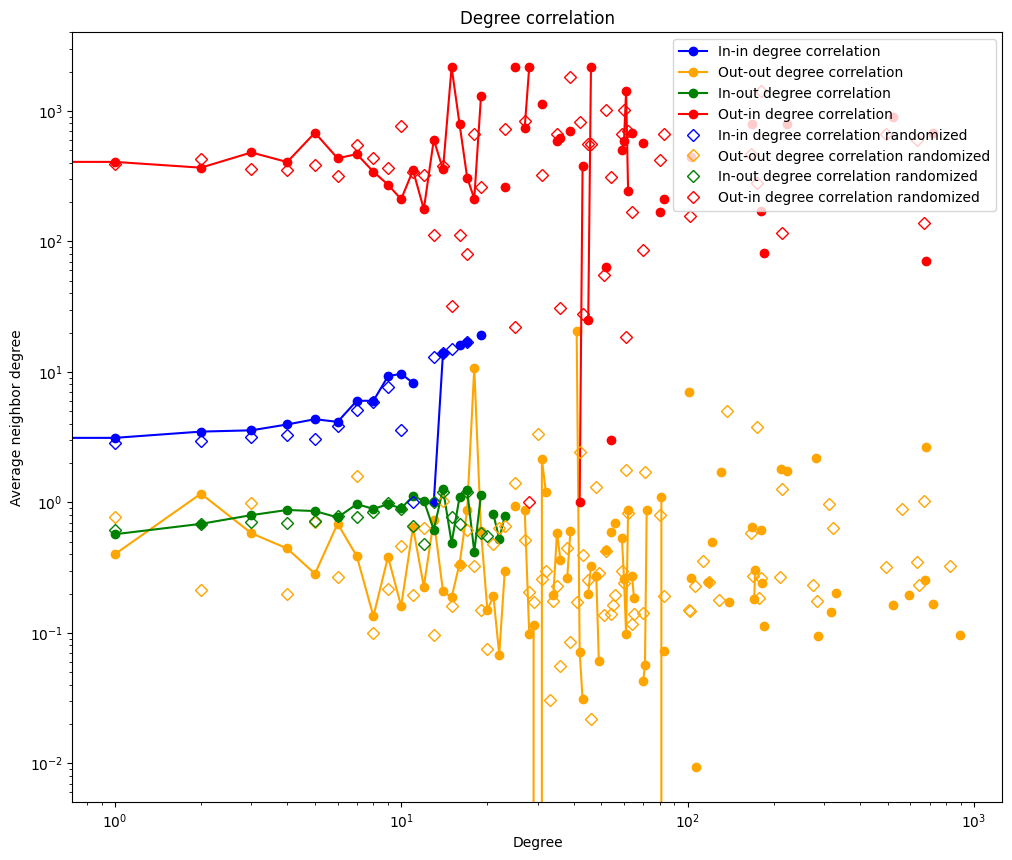

In [30]:
# Get the y values from the values of the dictionaries for the randomized network
y_values_in_in_randomized = [k_u_in_randomized.get(x, np.nan) for x in x_values]
y_values_out_out_randomized = [k_u_out_randomized.get(x, np.nan) for x in x_values]
y_values_in_out_randomized = [k_v_in_randomized.get(x, np.nan) for x in x_values]
y_values_out_in_randomized = [k_v_out_randomized.get(x, np.nan) for x in x_values]

# Plot the degree correlation
plt.figure(figsize=(12, 10))

plt.plot(x_values, y_values_in_in, label='In-in degree correlation', color='blue', marker = 'o')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation', color='orange', marker='o')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation', color='green', marker='o')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation', color='red', marker='o')

plt.plot(x_values, y_values_in_in_randomized, label='In-in degree correlation randomized', linestyle='None', marker = 'D', color = 'blue', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_out_randomized, label='Out-out degree correlation randomized', linestyle='None', marker = 'D', color = 'orange', markerfacecolor = 'None') 
plt.plot(x_values, y_values_in_out_randomized, label='In-out degree correlation randomized', linestyle='None', marker = 'D', color = 'green', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_in_randomized, label='Out-in degree correlation randomized', linestyle='None', marker = 'D', color = 'red', markerfacecolor = 'None')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")
plt.legend(loc='upper right')
plt.title("Degree correlation")
plt.savefig(f'{image_folder}Degree_correlation_randomized.png', bbox_inches='tight')
plt.show()

100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


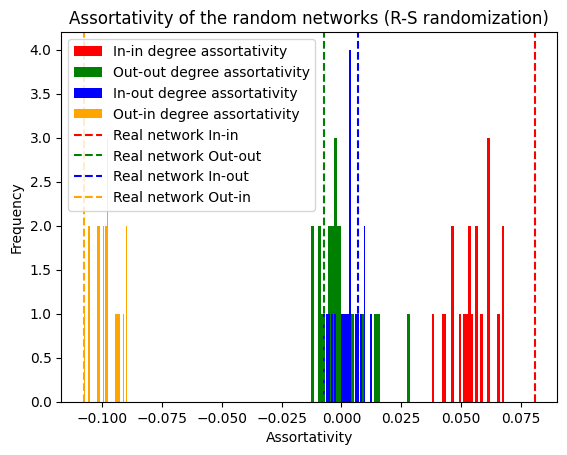

In [31]:
# Make the same two plots with the degree preserving randomization
r_in_in_R_S = []
r_out_out_R_S = []
r_in_out_R_S = []
r_out_in_R_S = []

for _ in tqdm(range(20)):
    g_r_s = degree_preserving_randomization(G)
    r_in_in, r_out_out, r_in_out, r_out_in = degree_assortativity_directed(g_r_s)
    r_in_in_R_S.append(r_in_in)
    r_out_out_R_S.append(r_out_out)
    r_in_out_R_S.append(r_in_out)
    r_out_in_R_S.append(r_out_in)

# Plot the distribution of the assortativities
plt.hist(r_in_in_R_S, bins=30, label='In-in degree assortativity', color='red')
plt.hist(r_out_out_R_S, bins=30, label='Out-out degree assortativity', color='green')
plt.hist(r_in_out_R_S, bins=30, label='In-out degree assortativity', color='blue')
plt.hist(r_out_in_R_S, bins=30, label='Out-in degree assortativity', color='orange')

# Plot the assortativity of the original network
plt.axvline(r_in_in_real, color='red', linestyle='--', label='Real network In-in')
plt.axvline(r_out_out_real, color='green', linestyle='--', label='Real network Out-out')
plt.axvline(r_in_out_real, color='blue', linestyle='--', label='Real network In-out')
plt.axvline(r_out_in_real, color='orange', linestyle='--', label='Real network Out-in')

plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the random networks (R-S randomization)')
plt.legend()
plt.savefig(f'{image_folder}Assortativity_column_R_S.png', bbox_inches='tight')
plt.show()

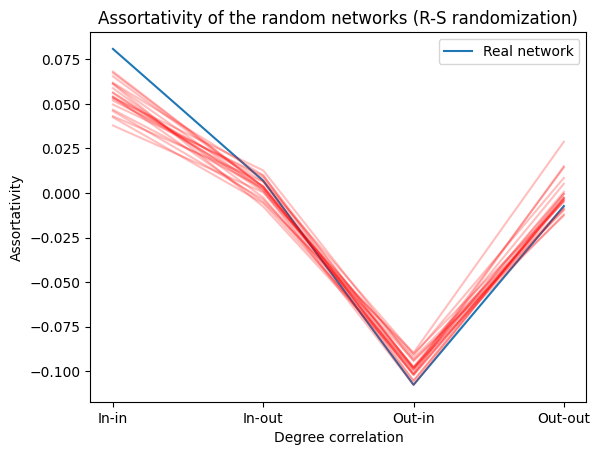

In [32]:
# Instead plot it as a line plot where the x_values are in_in, in_out, out_in, out_out:
x_values = ['In-in', 'In-out', 'Out-in', 'Out-out']

# Get the y values from the values of the dictionaries
y_values = [r_in_in_real, r_in_out_real, r_out_in_real, r_out_out_real]

fig = plt.figure()
plt.plot(x_values, y_values, label='Real network')
for i, (r_in_in, r_out_out, r_in_out, r_out_in) in enumerate(zip(r_in_in_R_S, r_out_out_R_S, r_in_out_R_S, r_out_in_R_S)):
    y_values = [r_in_in, r_in_out, r_out_in, r_out_out]
    plt.plot(x_values, y_values, alpha=0.25, color='red')

plt.xlabel("Degree correlation")
plt.ylabel("Assortativity")
plt.title("Assortativity of the random networks (R-S randomization)")
plt.legend()
plt.savefig(f'{image_folder}Assortativity_lineplot_R_S.png', bbox_inches='tight')
plt.show()

### Part 1 of Conclusion on the Graph Analysis.
The network of github is not random and it shows very clear signs of dissortativity

In [33]:
# Find the 5 most central packages according to degree centrality.
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print(f'The 5 most central packages according to closeness centrality are: {[str(package) for package, centrality in sorted_closeness_centrality[:5]]}')

# Find the 5 most central packages according to eigenvector centrality.
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print(f'The 5 most central packages according to eigenvector centrality are: {[str(package) for package, centrality in sorted_eigenvector_centrality[:5]]}')

The 5 most central packages according to closeness centrality are: ['dallinger', 'dxc-rl', 'genomic-embeddings', 'lenvert-python', 'meantools']
The 5 most central packages according to eigenvector centrality are: ['kfp', 'kfp-server-api', 'kfp-kubernetes', 'pytsv', 'elib-run']


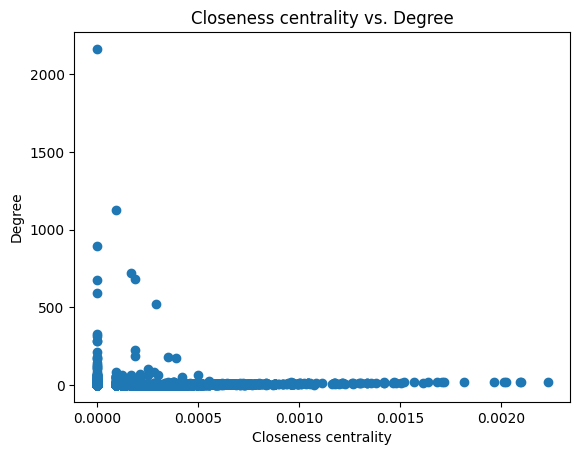

In [34]:
closeness_centrality = nx.closeness_centrality(G)
degree = dict(G.degree())
plt.scatter(list(closeness_centrality.values()), list(degree.values()))
plt.xlabel('Closeness centrality')
plt.ylabel('Degree')
plt.title('Closeness centrality vs. Degree')
plt.savefig(f'{image_folder}Closeness_vs_Degree.png', bbox_inches='tight')
plt.show()

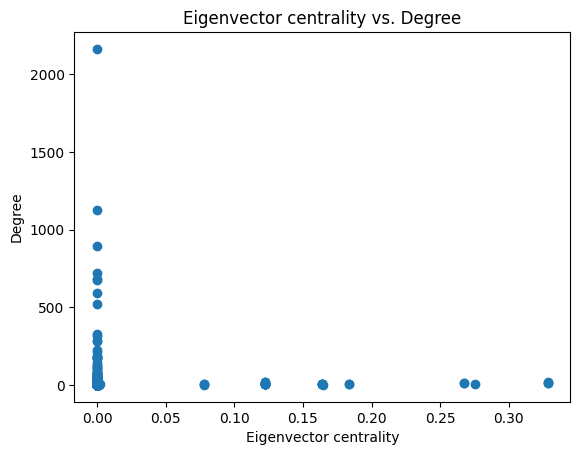

In [35]:
eigenvector_centrality = nx.eigenvector_centrality(G)
degree = dict(G.degree())
plt.scatter(list(eigenvector_centrality.values()), list(degree.values()))
plt.xlabel('Eigenvector centrality')
plt.ylabel('Degree')
plt.title('Eigenvector centrality vs. Degree')
plt.savefig(f'{image_folder}Eigenvector_vs_Degree.png', bbox_inches='tight')
plt.show()

### Part 2 of Conclusion on Graph Analysis.
bla bla

## Textual analysis of the found communities

In [36]:
# Find and assign all the communities to the dictionary
# First make the graph undirected: https://github.com/taynaud/python-louvain/issues/28 
# De snakker heller ikke rigtigt om hvordan man skulle gøre i bogen. Derudover er tidskompleksiteten O(L) af louvain
# MUST BE DELETED
G_undir = G.to_undirected()
partitioning = community_louvain.best_partition(G_undir)
print(len(set(partitioning.values())))
print({k: len([v for v in partitioning.values() if v == k]) for k in set(partitioning.values())})

41
{0: 618, 1: 1243, 2: 1242, 3: 112, 4: 6, 5: 188, 6: 7, 7: 250, 8: 923, 9: 59, 10: 605, 11: 238, 12: 372, 13: 118, 14: 179, 15: 92, 16: 5, 17: 492, 18: 137, 19: 323, 20: 15, 21: 380, 22: 8, 23: 112, 24: 89, 25: 81, 26: 100, 27: 14, 28: 13, 29: 472, 30: 122, 31: 122, 32: 30, 33: 8, 34: 24, 35: 472, 36: 495, 37: 740, 38: 5, 39: 73, 40: 64}


In [37]:
G_undir = G.to_undirected()
partition = nx.community.louvain_communities(G_undir)
print(len(partition))
print({i: len([v for v in p]) for i, p in enumerate(partition)})
print(nx.community.modularity(G_undir, partition))
partitioning = {node: i for i, p in enumerate(partition) for node in p}

40
{0: 1272, 1: 923, 2: 151, 3: 92, 4: 701, 5: 124, 6: 567, 7: 136, 8: 13, 9: 13, 10: 8, 11: 461, 12: 84, 13: 523, 14: 196, 15: 64, 16: 111, 17: 385, 18: 295, 19: 64, 20: 81, 21: 1197, 22: 258, 23: 146, 24: 198, 25: 71, 26: 187, 27: 445, 28: 6, 29: 159, 30: 135, 31: 7, 32: 14, 33: 5, 34: 380, 35: 8, 36: 340, 37: 5, 38: 474, 39: 349}
0.676696139927542


In [38]:
# colors = [partitioning[node] for node in G.nodes]
# nx.draw(G, with_labels=False, node_color=colors)

In [39]:
# Map a community number into one of 47 unique colors
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = plt.get_cmap('gist_ncar')
colors = [cmap(i) for i in np.linspace(0, 1, len(partition))]
colors = [colors[community] for community in partitioning.values()]

# Map the color to the corresponding package and save the pairs into a csv file
community_color = {package: color for package, color in zip(G.nodes, colors)}
community_color = pd.DataFrame(community_color.items(), columns=['id', 'color'])
community_color.to_csv("data/community_color.csv", index=False)

In [40]:
df = pd.read_csv("data/nodes_data.csv")
df = df.dropna(subset=['readme_text'])
# # Take 1/10 of the data
# df_subset = df.sample(frac=0.1, random_state=42)
# df = df_subset

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def tokenize(text, stop_words=stop_words, stemmer=stemmer):
    """
    Tokenize the text by removing stopwords, punctuation, and stemming the words.

    Parameters:
    - text (str): The input text.
    - stop_words (set): A set of stopwords.
    - stemmer (PorterStemmer): A stemmer object.

    Returns:
    - tokens (list): A list of tokens.
    """
    
    if text is None or '':
        return ''
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]

    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Apply the function to the readme's
df["tokens"] = df["readme_text"].apply(tokenize)

# Save the dataframe to a csv file
df.to_csv("data/nodes_tokens.csv", index=False)

# Combine the tokens from all abstracts into one comprehensive list.
all_tokens = df["tokens"].sum()

In [41]:
# Bigrams and contingency tables

# Function that creates bigrams from a list of tokens
bigrams = list(make_bigrams(all_tokens))
bigram_counts = Counter(bigrams)

# Function that creates a contingency table for a bigram
# Create a BigramCollocationFinder object that also stores tables at the same time
finder = BigramCollocationFinder.from_words(all_tokens)

# Computes for each unique bigram the chi-squared statistic between the observed and expected contingency tables
# Filter bigrams based on chi-squared
collocations_chisq = finder.score_ngrams(BigramAssocMeasures().chi_sq)

# Compute p-values for the chi-squared statistics
# Calculate chi-squared to get p-value
collocations_p = []
for bigram, chi_squared in tqdm(collocations_chisq):
    collocations_p.append((bigram, stats.chi2.sf(chi_squared, 1)))

# Find the list of bigrams that appear more than 50 times and have p-value smaller than 0.001
# Filter collocations based on p-value
collocations = [bigram for bigram, p_value in collocations_p if bigram_counts[bigram] > 50 and p_value < 0.001]

# Find the top 20 of them by number of occurrences
print(f'Top 20 collocations by number of occurrences: {collocations[:20]}')

# Combine collocations into a single token
collocation_tokens = ['_'.join(bigram) for bigram in collocations]

100%|██████████| 1979753/1979753 [03:18<00:00, 9977.81it/s] 


Top 20 collocations by number of occurrences: [('auditlogauditl', 'jsonifierjsonifi'), ('formattedpriceu', 'currencycodeusd'), ('jsonifierjsonifi', 'sentrys'), ('restructuredtextrst', 'markdownmd'), ('newstyleapi', 'newstyleapi'), ('dcimapi', 'dcimapi'), ('songid', 'albumid'), ('danmak', 'danmak'), ('traceinfo', 'displaycategoryid'), ('ipamapi', 'ipamapi'), ('promot', 'widespread'), ('customerapi', 'customerapi'), ('imageurl', 'umppric'), ('priceu', 'imageurl'), ('productdetailurl', 'traceinfo'), ('vice', 'versa'), ('accountapi', 'accountapi'), ('userapi', 'userapi'), ('whose', 'mission'), ('matplotlibpyplot', 'plt')]


In [42]:
def tokenize_with_collocations(text: str, collocations=collocation_tokens, stop_words=stop_words, stemmer=stemmer):
    """
    Tokenize the text by removing stopwords, punctuation, and stemming the words.

    Parameters:
    - text (str): The input text.
    - collocations (list): A list of collocations.
    - stop_words (set): A set of stopwords.
    - stemmer (PorterStemmer): A stemmer object.

    Returns:
    - tokens (list): A list of tokens.
    """

    if text is None or '':
        return ''
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Check all tokens and replace collocations with a single token
    for i in range(len(tokens) - 1):
        if f'{tokens[i]}_{tokens[i + 1]}' in collocations:
            tokens[i] = f'{tokens[i]}_{tokens[i + 1]}'
            tokens[i + 1] = ''
    tokens = [word for word in tokens if word != '']

    return tokens

df = pd.read_csv("data/nodes_tokens.csv")

# Apply the function to the readme's
df["collocations"] = df["readme_text"].apply(tokenize_with_collocations)

# Save the dataframe to a csv file
df.to_csv("data/nodes_collocations.csv", index=False)

In [51]:
df = pd.read_csv("data/nodes_collocations.csv")

# Use the partitioning for the packages get a coloumn with their partitioning in the df:
df['partition'] = df['package'].map(partitioning)

# Save the dataframe to a csv file
df.to_csv("data/nodes_partition.csv", index=False)

In [64]:
df = pd.read_csv("data/nodes_partition.csv")

# Select the top 10 communities
top_10_communities = df['partition'].value_counts().head(10).index

# Filter the dataframe on the top 10 communities
df_top_10 = df[df['partition'].isin(top_10_communities)]

# Create a dictionary with the top 10 communities and the corresponding tokens
top_10_community_terms = {}

for community in top_10_communities:
    # The tokens are a long string but should be read as individual lists
    tokens = df_top_10[df_top_10['partition'] == community]['tokens'].apply(ast.literal_eval)
    tokens = [token for sublist in tokens for token in sublist] 
    # only use term frequency
    vectorizer = TfidfVectorizer(use_idf = False)
    X = vectorizer.fit_transform([' '.join(tokens)])
    terms = vectorizer.get_feature_names_out()
    top_10_community_terms[community] = terms

# Get the 3 packages with most out nodes in each community
top_3_packages = {}

for community in top_10_communities:
    out_degrees = dict(G.out_degree())
    community_nodes = [node for node in G.nodes if partitioning[node] == community]
    out_degrees_community = {node: out_degrees[node] for node in community_nodes}
    top_3_packages[community] = sorted(out_degrees_community, key=out_degrees_community.get, reverse=True)[:3]

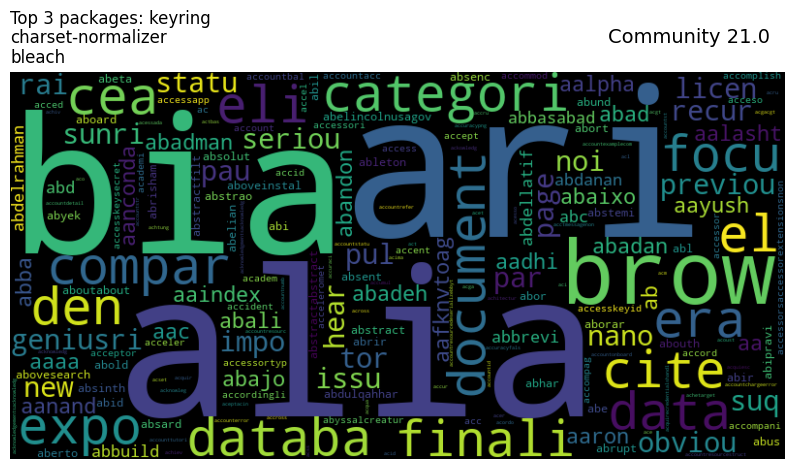

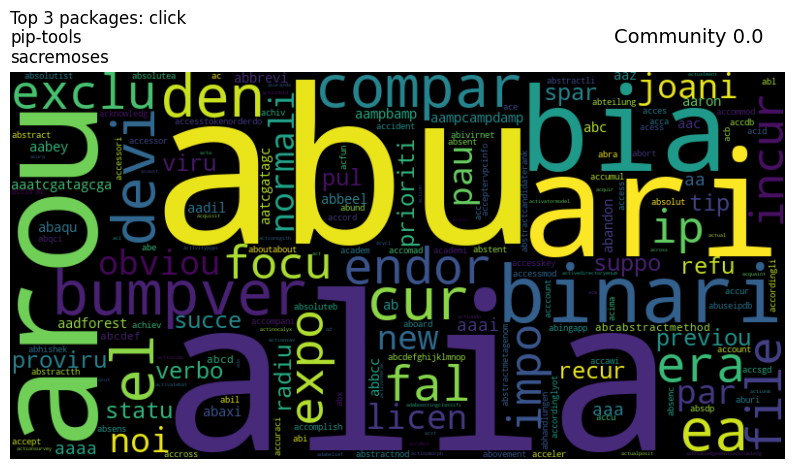

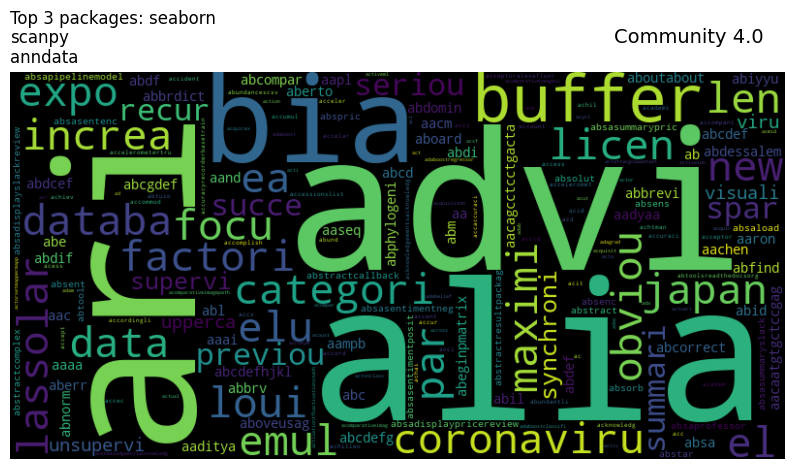

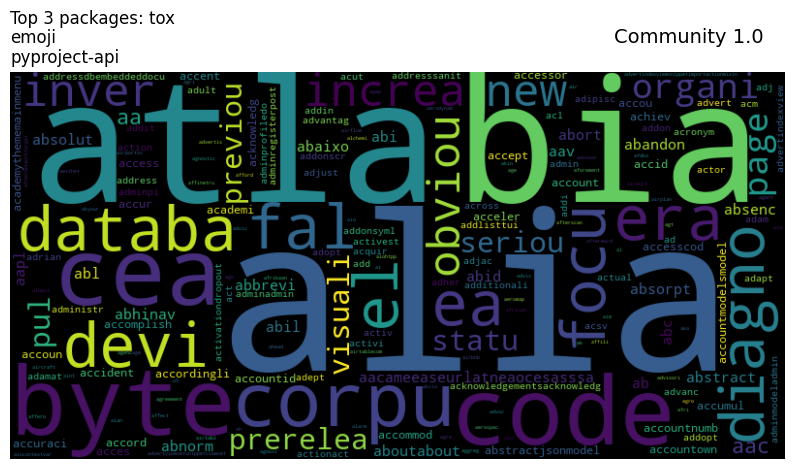

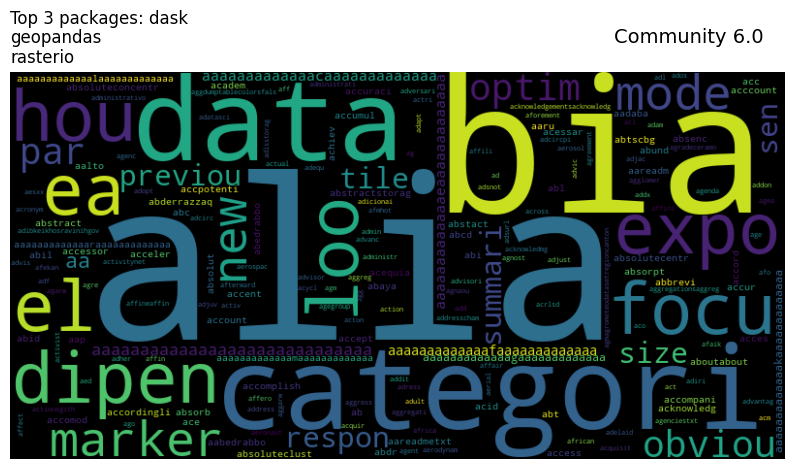

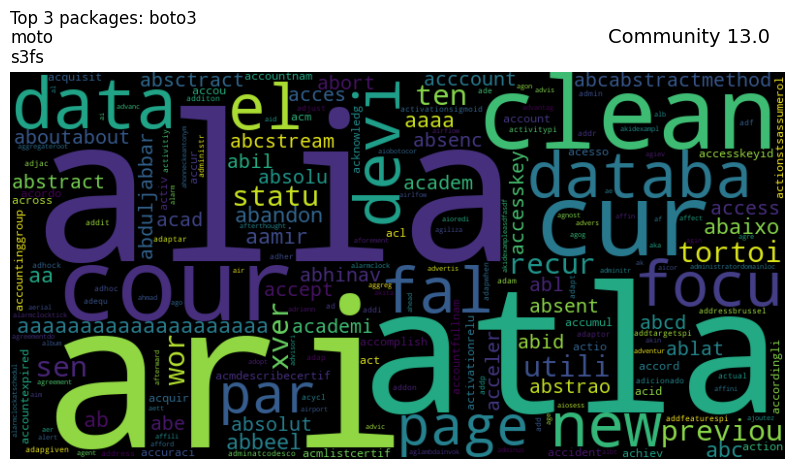

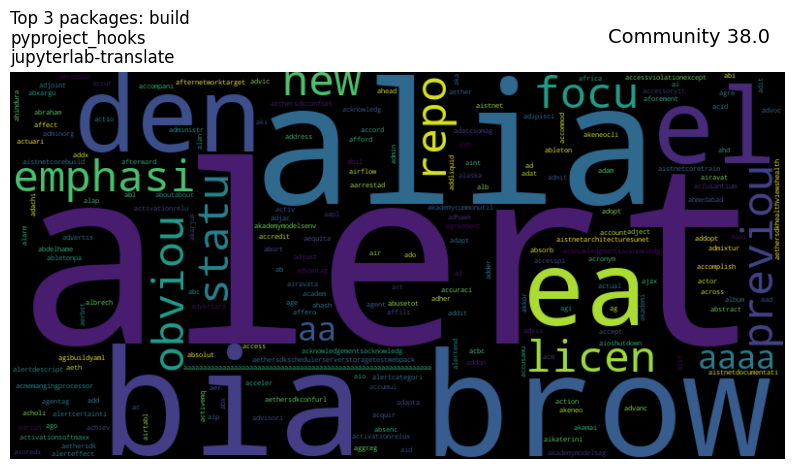

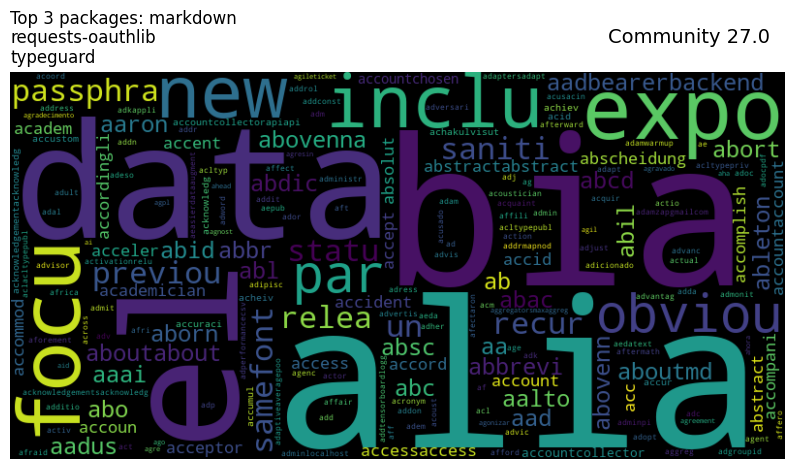

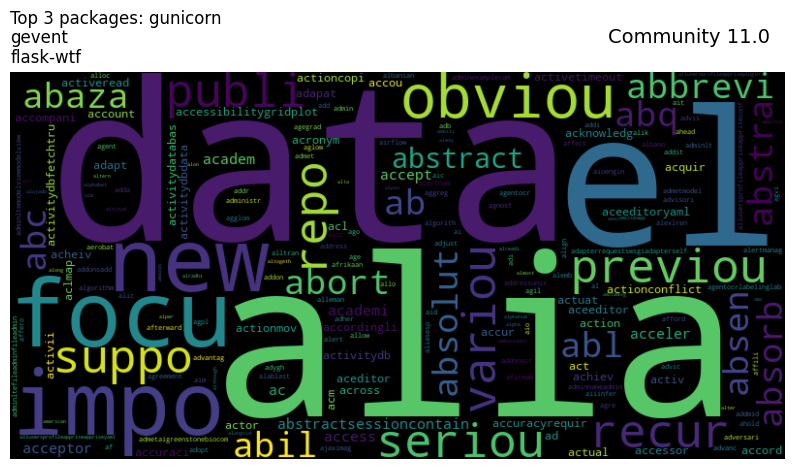

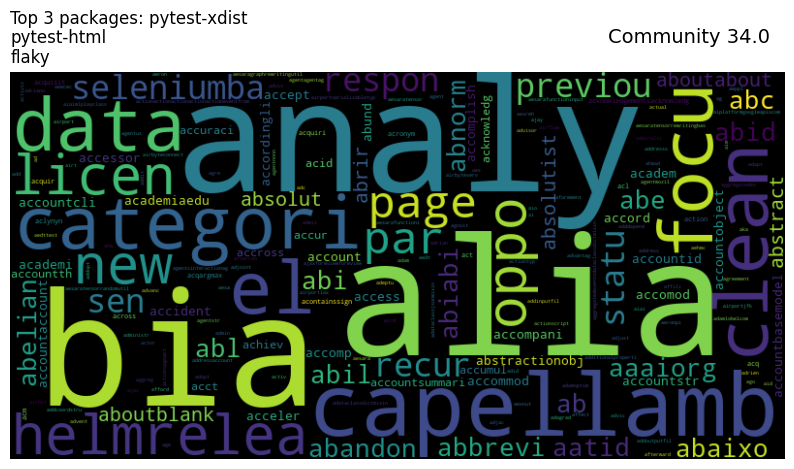

In [65]:
# Create a wordcloud with the information on the communities:
for community in top_10_communities:
    terms = top_10_community_terms[community]
    text = ' '.join(terms)
    wordcloud = wc.WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.text(700, -30, f'Community {community}', fontsize=14, color='black', ha='center')
    
    plt.text(0, -50, f'Top 3 packages: {top_3_packages[community][0]}', fontsize=12, color='black', zorder=1)
    plt.text(0, -30, f'{top_3_packages[community][1]}', fontsize=12, color='black', zorder=2)
    plt.text(0, -10, f'{top_3_packages[community][2]}', fontsize=12, color='black', zorder=3)
    
    plt.savefig(f'{image_folder}Community_{community}.png', bbox_inches='tight')
    plt.show()

In [ ]:
# Print the packages with most incomming edges in G:
